# Final Project - LES Rainfall prediction

- Submitted by Mubin Modi, Mitali Chouthai, Meghna Havalgi


## Contents 
- Introduction
- Data Preparation
    - Data Used :
        - Satelite Images of Cloud Cover
        - Meteorological Data
    - Processing :
        - Redundant Variables Drop 
        - Missing Values
        - Slicing of Images into 8hr buckets
        - Slicing of Meteo Data into 24 hr buckets
        - Creating a sliding window Precipitation (Target Label)
        - Min-Max Scaling
- Modeling:
    - Encoder-Decoder Architecture (ConvLSTM + LSTM)
    - Predictions
    - Performance Confusion Matrix
    - Prediction Examples
- Conclusion

## Data Description


This dataset contains hourly indexed GOES satellite imagery data and meteorology data, from `October 1, 2006 0:00` to `March 31, 2017 23:00`.


| Column Name           | Data Category     | Data Type                  | Description                                                  |
| :--------------------- | :-----------------: | :--------------------------: | :------------------------------------------------------------ |
| Date_UTC              | Timestamp         | `<String>`                 | The date of the data in the row in UTC timezone. This timezone is used by GOES satellites and the file naming follows the same convention. |
| Time_UTC              | Timestamp         | `<String>`                 | The time of the data in the row in UTC timezone. This timezone is used by GOES satellites and the file naming follows the same convention. |
| Date_CST              | Timestamp         | `<String>`                 | The date of the data in the row in UTC timezone. This timezone is used by weather station while collecting meteorology data. |
| Time_CST              | Timestamp         | `<String>`                 | The time of the data in the row in UTC timezone. This timezone is used by weather station while collecting meteorology data. |
| File_name_for_1D_lake | I/O               | `<String>`                 | The corresponding raw data file where the GOES satellite imagery data was extracted. Files can be found on server***. |
| File_name_for_2D_lake | I/O               | `<String>`                 | The corresponding processed data file where the GOES satellite imagery data was extracted. Files can be found on server***. |
| Lake_data_1D          | Satellite Imagery | `Array[<Float>]`           | 1-D array of floating point numbers which represent the flattened cloud pixel intensity of Lake Michigan area. The array has a length of `3,599`. |
| Lake_data_2D          | Satellite Imagery | `Array[Array[<Float>], …]` | 2-D array of floating point numbers which represent the cloud pixel intensity of Lake Michigan area. The structure of the array is: [[col 1], [col 2], ..], data can be used to reconstruct a 106 x 79 matrix. |
| Temp (F)              | Meteorology       | `<Integer>`                | Temperature (°F Dry Bulb)                                    |
| RH (%)                | Meteorology       | `<Float>`                  | Relative Humidity (%)                                        |
| Dewpt (F)             | Meteorology       | `<Integer>`                | Dew Point Temperature (°F)                                   |
| Wind Spd (mph)        | Meteorology       | `<Float>`                  | Wind Speed (mph)                                             |
| Wind Direction (deg)  | Meteorology       | `<Float>`                  | Wind Direction (degrees, measured every 10 degrees)          |
| Peak Wind Gust(mph)   | Meteorology       | `<Float>`                  | Wind Gust (mph)                                              |
| Low Cloud Ht (ft)     | Meteorology       | `<Float>`                  | Cloud Height—Lower Level of Cloud (feet)                     |
| Med Cloud Ht (ft)     | Meteorology       | `<Float>`                  | Cloud Height—Med Level of Cloud (feet)                       |
| High Cloud Ht (ft)    | Meteorology       | `<Float>`                  | Cloud Height—Upper Level of Cloud (feet)                     |
| Visibility (mi)       | Meteorology       | `<Float>`                  | Visibility (miles)                                           |
| Atm Press (hPa)       | Meteorology       | `<Float>`                  | Atmospheric Pressure (hPa, hecto-Pascals)                    |
| Sea Lev Press (hPa)   | Meteorology       | `<Float>`                  | Sea Level Pressure (hPa, hecto-Pascals)                      |
| Altimeter (hPa)       | Meteorology       | `<Float>`                  | Altimeter (hPa, hecto-Pascals)                               |
| Precip (in)           | Meteorology       | `<Float>`                  | Precipitation (inches)                                       |
| Wind Chill (F)        | Meteorology       | `<Integer>`                | Wind Chill (°F)                                              |
| Heat Index (F)        | Meteorology       | `<Integer>`                | Heat Index (°F)                                              |

**Non-numeric labels in meteorology data:**

> Missing values are indicated by "M" and "m". When observations note specific values as missing, "M" is used. The "m" is used when there is a lack of information from the observation.

`Lake_data_1D`: 

Each value in the array corresponds to a pixel within the Lake Michigan area. The longitude and latitude values of these pixels can be found in `2006Fall_2017Spring_GOES_meteo_combined.csv`. There are 3,599 data points which covers the Lake Michigan area.

`Lake_data_2D`: 

The 2-D array can be utilized to create a rectangular region that encompasses the Lake Michigan area. The area covers latitudes ranging from 41.78 to 45.98 with an increment of 0.04, and longitudes ranging from -87.90 to -84.78 with an increment of 0.04.

## 1) Introduction

In this project we need to create an amalgamation of CNN & RNN models to accurately forecast precipitaion of rain at Lake michigan and categorize into 4 categories: low, medium, high, none. But first we have tried to predict if 2 classes rain or no rain.
We have ~15K satelite images of lake michigan with frequent cloud cover and subsequent weather forecast specific variables with data at hour level <div>

We started with first creating a mapping between the images and the weather forecast data and then figured out how to structure our data to model forecating. It's important to note given it's forecasting we will also not have images for the following days to predict the precipitation, hence we have to create a sliding window based data and then train our models on it <div>

When we created the mapping, we observed that it is not necessary that there is clear match with precipitation and cloud image, but it would be sequence of images representing the flow of clouds over Lake Michigan which would indicate if it rains or not and the precipitation levels <div>

This was a critical finding and with Professor's hint on using `ConvLSTM` for the sequence of images, we were able to connect the dots. We then worked on to create classic Encoder-Decoder style architecture to use `ConvLSTM` for extracting feature from sequence of images, and `LSTM` for the time series Meteorological <div>


## 2) Data Preparation

### Importing Libraries

In [1]:
import pandas as pd
from tqdm import tqdm
import cv2
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model, load_model
from keras.layers import Input, LSTM, ConvLSTM2D, Dense, Add, Dropout, Flatten, Reshape
from keras.layers import TimeDistributed, BatchNormalization
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

### Importing Satelite Images of Lake Michigan

These are preprocessed images specifically focused on cloud cover on lake michigan ~15K in total

Loading images then converting them to numpy array

If valid images are found, they are batched using TensorFlow's timeseries_dataset_from_array function. This function is particularly useful for preparing datasets for time series forecasting models like LSTMs or ConvLSTMs.


## Images were generated in a different notebook

In [2]:
import numpy as np

#Loading images correctly
images = []
for idx in tqdm(range(12000)):
    im_path = f'C:/Users/Administrator/Desktop/Files/NN/images/lake-michigan-images-64-combined/{idx}.png'
    im = cv2.imread(im_path)
    if im is not None:
        images.append(im)
    else:
        print(f"Failed to load the image: {im_path}")

#Converting images to numpy array
images = np.array(images)

#Checking if the image data is valid
if images.size > 0:
    cloud_train_batched = tf.keras.preprocessing.timeseries_dataset_from_array(
        images[:10000], None, 8, sequence_stride=8, sampling_rate=1, batch_size=10000
    )

    for batch in cloud_train_batched:
        print(batch.shape)
        break  
else:
    print("No valid image data found.")

100%|██████████████████████████████████████████████████████████████████████████| 12000/12000 [00:04<00:00, 2839.33it/s]


(1250, 8, 64, 64, 3)


### Reading the Meteorological data

LES Meteorological data consists of many features with the target variable of Precipitation starting from 2006 to 2017. We would focus on relevant 10 features like Temperature, Dew point etc and create a smaller subset

In [3]:
len(images)

12000

In [4]:
les = pd.read_csv(r"D:\Data\2006Fall_2017Spring_GOES_meteo_combined.csv")

In [5]:
# Renaming
les.rename(columns={ "Temp (F)": "Temp_F", "RH (%)": "RH_pct",
                   "Dewpt (F)" : "Dewpt_F", "Wind Spd (mph)" : "Wind_Spd_mph",
                   "Wind Direction (deg)" : "Wind_Direction_deg", "Peak Wind Gust(mph)" : "Peak_Wind_Gust_mph",
                   "Low Cloud Ht (ft)" : "Low_Cloud_Ht_ft", "Med Cloud Ht (ft)" : "Med_Cloud_Ht_ft",
                   "High Cloud Ht (ft)" : "High_Cloud_Ht_ft", "Visibility (mi)" : "Visibility_mi",
                   "Atm Press (hPa)" : "Atm_Press_hPa", "Sea Lev Press (hPa)" : "Sea_Lev_Press_hPa",
                   "Altimeter (hPa)" : "Altimeter_hPa", "Precip (in)" : "Precip_in",
                   "Wind Chill (F)" : "Wind_Chill_F", "Heat Index (F)" : "Heat_Index_F",
                   } , inplace = True)

les.head()

,Date_UTC,Time_UTC,Date_CST,Time_CST,File_name_for_1D_lake,File_name_for_2D_lake,Lake_data_1D,Lake_data_2D,Temp_F,RH_pct,...,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,Precip_in,Wind_Chill_F,Heat_Index_F
0,2006-10-01,00:00,2006-09-30,00:00,goes11.2006.10.01.0000.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0000.v01.nc-var1-t0.csv.csv,"[0.0075, 0.0025, 0.0, 0.005, 0.0, 0.005, nan, ...","[array([ nan, nan, nan, nan, nan...",48,86,...,4100,4800,7000,10,984.0,1007.00,1006.80,0.00,45,NC
1,2006-10-01,01:00,2006-09-30,01:00,goes11.2006.10.01.0100.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0100.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0025, nan, 0.0, nan, 0...","[array([ nan, nan, nan, nan, nan...",48,86,...,6000,m,m,10,983.7,1006.50,1006.40,0.00,44,NC
2,2006-10-01,02:00,2006-09-30,02:00,goes11.2006.10.01.0200.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0200.v01.nc-var1-t0.csv.csv,"[0.0, nan, 0.0075, nan, nan, 0.0025, nan, nan,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,...,5500,11000,m,10,982.7,1005.70,1005.40,0.00,45,NC
3,2006-10-01,03:00,2006-09-30,03:00,goes11.2006.10.01.0300.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0300.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0, 0.0075, nan, 0.005,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,...,6000,m,m,10,982.0,1005.10,1004.70,0.00,44,NC
4,2006-10-01,04:00,2006-09-30,04:00,goes11.2006.10.01.0400.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0400.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0, nan, 0.0075, 0.0, nan, nan,...","[array([ nan, nan, nan, nan, nan...",48,89,...,2200,3500,m,8,982.0,1004.90,1004.70,0.02,46,NC


Replacing missing values with 0 and dropping the columns WindChill and Heat Index due to a large number of NC values

In [6]:
les = les.replace(['m', 'M'], '0')
les = les.drop(['Wind_Chill_F', 'Heat_Index_F'], axis=1)
les = les.reset_index(drop=True)
les = les.dropna(subset = ['Temp_F'])

In [7]:
les.columns

Index(['Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake',
       'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Temp_F',
       'RH_pct', 'Dewpt_F', 'Wind_Spd_mph', 'Wind_Direction_deg',
       'Peak_Wind_Gust_mph', 'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
       'High_Cloud_Ht_ft', 'Visibility_mi', 'Atm_Press_hPa',
       'Sea_Lev_Press_hPa', 'Altimeter_hPa', 'Precip_in'],
      dtype='object')

### Dropping highly correlated features

Some highly correlated and redundant features are removed from the dataset. These include 'Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake', 'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Dewpt_F', 'Peak_Wind_Gust_mph', and potentially 'Altimeter_hPa', due to its high correlation with 'Atm_Press_hPa'

In [8]:
les.columns

Index(['Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake',
       'File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_2D', 'Temp_F',
       'RH_pct', 'Dewpt_F', 'Wind_Spd_mph', 'Wind_Direction_deg',
       'Peak_Wind_Gust_mph', 'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
       'High_Cloud_Ht_ft', 'Visibility_mi', 'Atm_Press_hPa',
       'Sea_Lev_Press_hPa', 'Altimeter_hPa', 'Precip_in'],
      dtype='object')

In [9]:
meteo_les = les.drop(
    [ 'Date_UTC', 'Time_UTC', 'Date_CST', 'Time_CST', 'File_name_for_1D_lake', 'File_name_for_2D_lake', 
     'Lake_data_1D', 'Lake_data_2D', 'Dewpt_F', 'Peak_Wind_Gust_mph', 'Altimeter_hPa' ], axis=1)

In [10]:
meteo_les.head()

,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Precip_in
0,48,86,7,150,4100,4800,7000,10,984.0,1007.00,0.00
1,48,86,8,150,6000,0,0,10,983.7,1006.50,0.00
2,48,86,6,0,5500,11000,0,10,982.7,1005.70,0.00
3,48,86,8,150,6000,0,0,10,982.0,1005.10,0.00
4,48,89,5,0,2200,3500,0,8,982.0,1004.90,0.02


In [11]:
len(meteo_les)

47882

### Creating Slices of 24hr with Meteo data

We create slices with 24 hours of data to represent daily observations

This method of slicing is crucial for modeling as it structures the data into a format suitable for time-series analysis, enabling the model to recognize patterns across each day.

In [12]:
x3 = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[0:30000], None, 24, sequence_stride=24, 
                                                                   sampling_rate=1, batch_size=30000)

In [13]:
for batch in x3:
    print(batch.shape)
    print('--')

(1250, 24, 11)
--


The dataset comprises 1250 observations of 24-hour meteorological data, each containing 11 features. For training and validation split we would use initial 30000 data points for `Train` and rest for `Validation` data

In [14]:
meteo_train_batched = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[0:30000], None, 24, sequence_stride=24, 
                                                                   sampling_rate=1, batch_size=30000)

In [15]:
meteo_train_batched

<BatchDataset element_spec=TensorSpec(shape=(None, None, 11), dtype=tf.string, name=None)>

In [16]:
def convert_byte_tensor_to_float(tensor):
    string_tensor = tf.strings.regex_replace(tensor, '^b\'(.*)\'$', '\\1')
    float_tensor = tf.strings.to_number(string_tensor, out_type=tf.float32)
    return float_tensor

In [17]:
meteo_train = None
for batch in meteo_train_batched:
    meteo_train = batch
    print(meteo_train.shape)
    print('--')

(1250, 24, 11)
--


In [18]:
print(meteo_train[0])

tf.Tensor(
[[b'48' b'86' b'7' b'150' b'4100' b'4800' b'7000' b'10' b'984.0'
  b'1007.00' b'0.00']
 [b'48' b'86' b'8' b'150' b'6000' b'0' b'0' b'10' b'983.7' b'1006.50'
  b'0.00']
 [b'48' b'86' b'6' b'0' b'5500' b'11000' b'0' b'10' b'982.7' b'1005.70'
  b'0.00']
 [b'48' b'86' b'8' b'150' b'6000' b'0' b'0' b'10' b'982.0' b'1005.10'
  b'0.00']
 [b'48' b'89' b'5' b'0' b'2200' b'3500' b'0' b'8' b'982.0' b'1004.90'
  b'0.02']
 [b'48' b'89' b'6' b'0' b'2700' b'5500' b'7500' b'10' b'981.7' b'1004.60'
  b'0.01']
 [b'42' b'95' b'0' b'0' b'4600' b'0' b'0' b'8' b'991.7' b'1014.80'
  b'0.00']
 [b'43' b'96' b'0' b'0' b'3900' b'0' b'0' b'10' b'992.3' b'1015.60'
  b'0.00']
 [b'48' b'92' b'0' b'0' b'3600' b'0' b'0' b'10' b'993.0' b'1016.30'
  b'0.00']
 [b'55' b'59' b'11' b'300' b'3600' b'0' b'0' b'10' b'993.7' b'1016.90'
  b'0.00']
 [b'55' b'61' b'10' b'300' b'3600' b'0' b'0' b'10' b'994.3' b'1017.50'
  b'0.00']
 [b'58' b'55' b'8' b'290' b'3600' b'0' b'0' b'10' b'995.0' b'1018.00'
  b'0.00']
 [b'56' b'

Removing the byte representation from the data

In [19]:
meteo_train = tf.map_fn(
    lambda batch: tf.map_fn(
        lambda sample: convert_byte_tensor_to_float(sample),
        batch,
        dtype=tf.float32),
    meteo_train,
    dtype=tf.float32)

In [20]:
meteo_train.shape

TensorShape([1250, 24, 11])

Summing the precipitation values for each hour of the day 

In [21]:
rain_train = []

for sample in meteo_train:
    last_column = sample[:, -1]

    # Sum the values in the last column
    rain_sum = tf.reduce_sum(last_column)

    # Append the sum to rain_train
    rain_train.append(rain_sum)

rain_train = tf.stack(rain_train)

##  Create classes- 0 = No Rain, 1= Low Rain, 2 = Medium Rain, 3 = High Rain

In [22]:
# if > 0.10 inches of rain, then rain = 1, else rain = 0
#rain_train_b = tf.where(rain_train > 0.10, 1, 0)

In [23]:


import numpy as np
import tensorflow as tf

# Assuming you have already computed `rain_train`

# Define thresholds for each category
none_threshold = 0.0  # No rain
low_threshold = 0.1  # Low rain
medium_threshold = 0.5  # Medium rain
high_threshold = 1.0  # High rain

# Create labels based on thresholds
rain_train_b = tf.zeros_like(rain_train, dtype=tf.int32)  # Initialize all labels to "none"
rain_train_b = tf.where(rain_train > low_threshold, 1, rain_train_b)  # Assign "low" label
rain_train_b = tf.where(rain_train > medium_threshold, 2, rain_train_b)  # Assign "medium" label
rain_train_b = tf.where(rain_train > high_threshold, 3, rain_train_b)  # Assign "high" label

# Count occurrences in each bin using TensorFlow
counts = [tf.reduce_sum(tf.cast(rain_train_b == i, tf.int32)) for i in range(4)]

# Print counts
print("Counts for each bin:")
print("None:", counts[0].numpy())
print("Low:", counts[1].numpy())
print("Medium:", counts[2].numpy())
print("High:", counts[3].numpy())


Counts for each bin:
None: 1060
Low: 172
Medium: 14
High: 4


In [24]:
# import matplotlib.pyplot as plt
# import tensorflow as tf

# # Assuming you have already computed `rain_train`

# plt.figure(figsize=(10, 6))
# plt.hist(rain_train_b, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
# plt.xlabel('Rainfall Sum', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
# plt.title('Distribution of Rainfall Sum', fontsize=16)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.grid(True)
# plt.show()


In [25]:
len(rain_train_b)

1250

As we can observe below, there are only 190 days, where it rains which makes the data highly imbalanced. We'll be treating the imabalance going forward, with class-weights during our training

In [26]:
rain_train_b

<tf.Tensor: shape=(1250,), dtype=int32, numpy=array([0, 0, 3, ..., 1, 0, 0])>

In [27]:
pd.Series(rain_train_b.numpy()).value_counts()

0    1060
1     172
2      14
3       4
Name: count, dtype: int64

Dropping the precipitation column from the meteo training data

In [28]:
meteo_train = meteo_train[:, :, :-1]
print(meteo_train.shape)

(1250, 24, 10)


### Min-Max Scaling

Scaling is an important step to create a scaled data as it avoids any unnecessary spikes in the data and ensures better training for the model

In [29]:
scaler = MinMaxScaler()

n_samples, n_timesteps, n_features = meteo_train.shape
meteo_train= tf.reshape(meteo_train, [n_samples * n_timesteps, n_features])
meteo_train = meteo_train.numpy()
meteo_train = scaler.fit_transform(meteo_train)
meteo_train = tf.reshape(meteo_train, [n_samples, n_timesteps, n_features]).numpy()

In [30]:
meteo_train.shape

(1250, 24, 10)

**The validation dataset for imagery begins at index 13,050, with a total of 15,959 instances of imagery recorded. The last 2,500 instances of imagery are designated as the validation dataset, excluding some intermediate 'nan' instances. This corresponds to 7,500 rows of meteorological data**

**Creates a dataset of sliding windows over a timeseries provided as array.**

In [31]:
meteo_val_batched = tf.keras.preprocessing.timeseries_dataset_from_array(meteo_les[:7500], None, 24, sequence_stride=24, 
                                                                   sampling_rate=1, batch_size=7500)

In [32]:
meteo_val = None
for batch in meteo_val_batched:
    meteo_val = batch
    print(meteo_val.shape)
    print('--')

(312, 24, 11)
--


In [33]:
meteo_val = tf.map_fn(
    lambda batch: tf.map_fn(
        lambda sample: convert_byte_tensor_to_float(sample),
        batch,
        dtype=tf.float32),
    meteo_val,
    dtype=tf.float32)

In [34]:
rain_val= []

for sample in meteo_val:
    last_column = sample[:, -1]

    rain_sum = tf.reduce_sum(last_column)

    rain_val.append(rain_sum)

rain_val = tf.stack(rain_val)

In [35]:
# if > 0.10 inches of rain, then rain = 1, else rain = 0
#rain_val_b = tf.where(rain_val > 0.10, 1, 0)

In [36]:


# Assuming you have already computed `rain_val`

# Define thresholds for each category
none_threshold = 0.0  # No rain
low_threshold = 0.1  # Low rain
medium_threshold = 0.5  # Medium rain
high_threshold = 1.0  # High rain

# Create labels based on thresholds
rain_val_b = tf.zeros_like(rain_val, dtype=tf.int32)  # Initialize all labels to "none"
rain_val_b = tf.where(rain_val > low_threshold, 1, rain_val_b)  # Assign "low" label
rain_val_b = tf.where(rain_val > medium_threshold, 2, rain_val_b)  # Assign "medium" label
rain_val_b = tf.where(rain_val > high_threshold, 3, rain_val_b)  # Assign "high" label

# Count occurrences in each bin using TensorFlow
counts = [tf.reduce_sum(tf.cast(rain_val_b == i, tf.int32)) for i in range(4)]

# Print counts
print("Counts for each bin:")
print("None:", counts[0].numpy())
print("Low:", counts[1].numpy())
print("Medium:", counts[2].numpy())
print("High:", counts[3].numpy())


Counts for each bin:
None: 264
Low: 44
Medium: 3
High: 1


In [37]:
meteo_val = meteo_val[:, :, :-1]

Scaling Validation data based on the train values

In [38]:
n_samples_val, n_timesteps_val, n_features_val = meteo_val.shape
meteo_val = tf.reshape(meteo_val, [n_samples_val * n_timesteps_val, n_features_val])
meteo_val = meteo_val.numpy()
meteo_val = scaler.transform(meteo_val)
meteo_val = tf.reshape(meteo_val, [n_samples_val, n_timesteps_val, n_features_val]).numpy()

In [39]:
meteo_val.shape

(312, 24, 10)

In [40]:
print(len(images))

12000


So we have about 3 times more training data than test data.

### Creating Image data 8hr window slices 

Our training dataset will consist of 8 hour sequence of images and the label will be rain or not for *the next day* (Sliding window 1-day shift)

In [41]:

num_classes = 4

# Perform one-hot encoding
rain_train_b_one_hot = tf.one_hot(rain_train_b, depth=num_classes)
rain_val_b_one_hot = tf.one_hot(rain_val_b, depth=num_classes)


In [42]:

rain_train_b_one_hot
rain_val_b_one_hot 


<tf.Tensor: shape=(312, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)>

In [43]:
cloud_train_batched = tf.keras.preprocessing.timeseries_dataset_from_array(images[:10000], None, 8, sequence_stride=8, 
                                                                           sampling_rate=1, batch_size=10000)

In [44]:
cloud_train = None
for batch in cloud_train_batched:
    cloud_train = batch
    cloud_train = np.expand_dims(cloud_train, axis=-1)
    print(cloud_train.shape)
    cloud_train = cloud_train / 255
    print('--')

(1250, 8, 64, 64, 3, 1)
--


For Validation set we take the last 2500 values

In [45]:
cloud_val_batched = tf.keras.preprocessing.timeseries_dataset_from_array(images[:2500], None, 8, sequence_stride=8, 
                                                                         sampling_rate=1, batch_size=2500)

In [46]:
cloud_val = None
for batch in cloud_val_batched:
    cloud_val = batch
    cloud_val = np.expand_dims(cloud_val, axis=-1)
    print(cloud_val.shape)
    cloud_val = cloud_val / 255
    print('--')

(312, 8, 64, 64, 3, 1)
--


In [47]:
# Assign rain train c as array from rain train b
rain_train_c = rain_train_b_one_hot.numpy()

In [48]:
rain_val_c = rain_val_b_one_hot.numpy()

the goal is to predict the next value based on previous data, aligning the current label with the previous timestep’s features.

In [49]:
rain_train_c_mod = [rain_train_c[x+1] for x in range(len(rain_train_c)-1)]
len(rain_train_c_mod)

1249

In [50]:
rain_val_c_mod = [rain_val_c[x+1] for x in range(len(rain_val_c)-1)]

In [51]:
print(rain_train_c[0:10], rain_train_c_mod[0:10])

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]] [array([1., 0., 0., 0.], dtype=float32), array([0., 0., 0., 1.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([0., 1., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([0., 1., 0., 0.], dtype=float32)]


In [52]:
cloud_train.shape, rain_train_c.shape, cloud_val.shape, rain_val_c.shape

((1250, 8, 64, 64, 3, 1), (1250, 4), (312, 8, 64, 64, 3, 1), (312, 4))

**Modelling**

We are using encoder-decoder architecture. Here we are using ConvLSTm for image feature extraction.
We are using LSTM for meteo time series data. We combine these two and feed it to the decoder layer. In the decoder layer we have LSTM and it generates the output forecast

In [53]:
# Drop the last value from each of the training datasets
meteo_train = meteo_train[:-1]
cloud_train = cloud_train[:-1]

# Drop the last value from each of the validation datasets
meteo_val = meteo_val[:-1]
cloud_val = cloud_val[:-1]

In [54]:
meteo_train = np.asarray(meteo_train)
cloud_train = np.asarray(cloud_train)
rain_train_c_mod = np.asarray(rain_train_c_mod)

meteo_val = np.asarray(meteo_val)
cloud_val = np.asarray(cloud_val)
rain_val_c_mod = np.asarray(rain_val_c_mod)

In [55]:
print(meteo_train.shape, cloud_train.shape, rain_train_c_mod.shape, meteo_val.shape, cloud_val.shape, rain_val_c_mod.shape)

(1249, 24, 10) (1249, 8, 64, 64, 3, 1) (1249, 4) (311, 24, 10) (311, 8, 64, 64, 3, 1) (311, 4)


We are using LSTM layers to process the meteo data and ConvLSTM2D for spatial temporal cloud imagery. We merge both the features and then merged features are decoded in the decoder layer by using additional LSTM layers and dropout regularization and finally passed through a dense layer to predict the precipitation.

### We use the same Model Architectures as we did in the previous notebook taking in Account the changes need for the multi-class classification

In [56]:
from tensorflow.keras.layers import Input, LSTM, Dropout, ConvLSTM2D, BatchNormalization, GlobalAveragePooling2D, Dense, Reshape, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Specifying the input shapes
meteo_input = Input(shape=(24, 10))
cloud_input = Input(shape=(8, 64, 64, 3))

## Encoder Layers 

# Starting with LSTM for Meteorological Data 
lstm_encoder = LSTM(64, return_sequences=True)(meteo_input)
lstm_encoder = Dropout(0.3)(lstm_encoder)
lstm_encoder = LSTM(32, return_sequences=False)(lstm_encoder)
lstm_encoder = BatchNormalization()(lstm_encoder)

# Followed by ConvLSTM for Cloud Data
convlstm_1 = ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True)(cloud_input)
convlstm_1 = Dropout(0.3)(convlstm_1)
convlstm_2 = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False)(convlstm_1)
convlstm_2 = BatchNormalization()(convlstm_2)

# Combining the outputs of the LSTM and ConvLSTM layers
combined_features = Add()([lstm_encoder, convlstm_2])

# Reduce spatial dimensions before reshaping
pooled = GlobalAveragePooling2D()(combined_features)

# Decoder Layers
decoder_1 = Dense(64, activation='relu')(pooled)
decoder_1 = Dropout(0.3)(decoder_1)
output = Dense(4, activation='sigmoid')(decoder_1)

model_lstm_ml = Model(inputs=[meteo_input, cloud_input], outputs=output)

new_learning_rate = 0.0001
optimizer = Adam(learning_rate=new_learning_rate)

model_lstm_ml.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model_lstm_ml.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 10)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 8, 64, 64,   0           []                               
                                3)]                                                               
                                                                                                  
 lstm (LSTM)                    (None, 24, 64)       19200       ['input_1[0][0]']                
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, 8, 64, 64, 1  11008       ['input_2[0][0]']            

Adding class weights to the data 80% for class 1 and 20% for class 0 to handle the imapct of class imbalance, we chose 80% to counter-allocate the class imabalance of the labels

**Class weights are used to address class imbalance in the training data.**

**Desired Weights for Each Class:**
- We define a list of desired weights for each class based on their importance or representation in the dataset. For example, `desired_weights = [0.1, 0.5, 0.4, 0.3]` indicates the desired weight for each class (in this case, four classes).

**Weight Calculation for Each Class:**
- To ensure that the sum of weights across all classes equals 1, we calculate the total desired weight by summing up all the desired weights (`total_desired_weight`).
- Then, we compute the weight for each class by dividing its desired weight by the total desired weight. This normalization ensures that the weights are proportional to the desired importance of each class.

**Class Weight Dictionary Creation:**
- We construct a dictionary (`class_weight_dict`) where each class index is mapped to its corresponding calculated weight. This dictionary serves as input to the model during training.

**Training with Class Weights:**
- During model training, the `fit()` method is invoked with the training data, labels, and additional parameters.
- We specify the `class_weight` parameter, passing the `class_weight_dict`. This informs the model to use the calculated class weights to adjust the loss function during training, thereby addressing class imbalance.
mbalance.

In [57]:
# Define the desired weights for each class
desired_weights = [0.1, 0.5, 0.4, 0.3]

# Calculate the weight for each class
total_desired_weight = sum(desired_weights)
class_weights = [weight / total_desired_weight for weight in desired_weights]

# Create the class weight dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

history = model_lstm_ml.fit(
    [meteo_train, cloud_train],
    rain_train_c_mod,
    epochs=50,
    batch_size=10,
    validation_data=([meteo_val, cloud_val], rain_val_c_mod),
    class_weight=class_weight_dict)



Epoch 1/50
125/125 [==============================] - 46s 267ms/step - loss: 0.1713 - accuracy: 0.4700 - val_loss: 1.3210 - val_accuracy: 0.7331
Epoch 2/50
125/125 [==============================] - 32s 257ms/step - loss: 0.1483 - accuracy: 0.6293 - val_loss: 1.2438 - val_accuracy: 0.6302
Epoch 3/50
125/125 [==============================] - 32s 257ms/step - loss: 0.1314 - accuracy: 0.6565 - val_loss: 1.1517 - val_accuracy: 0.5113
Epoch 4/50
125/125 [==============================] - 32s 257ms/step - loss: 0.1213 - accuracy: 0.6886 - val_loss: 0.9744 - val_accuracy: 0.5916
Epoch 5/50
125/125 [==============================] - 32s 257ms/step - loss: 0.1136 - accuracy: 0.6829 - val_loss: 0.8243 - val_accuracy: 0.6817
Epoch 6/50
125/125 [==============================] - 32s 258ms/step - loss: 0.1157 - accuracy: 0.6902 - val_loss: 0.7523 - val_accuracy: 0.6913
Epoch 7/50
125/125 [==============================] - 32s 257ms/step - loss: 0.1086 - accuracy: 0.6853 - val_loss: 0.6857 - val_ac

In [87]:
model_lstm_ml.save('multiclass_deep_model.h5')

Precision:

- Class 0 (None): 85% of instances predicted as "None" were actually "None."
- Class 1 (Low): 14% of instances predicted as "Low" were actually "Low."
- Classes 2 and 3: Both have very low precision, indicating the model's struggle to correctly classify instances into these classes.

Recall:

- Class 0 (None): The model correctly identified all instances of "None."
- Class 1 (Low): The model captured 100% of "Low" instances.
- Classes 2 and 3: The model failed to identify any instances of these classes.

F1-score:

- Class 0 (None): A high F1-score of 0.92 indicates a good balance between precision and recall.
- Class 1 (Low): A lower F1-score of 0.25 reflects the imbalance between precision and recall.
- Classes 2 and 3: Both have F1-scores of 0.04, indicating poor performance due to low precision and recall.

Support:

- Class 0 (None): The highest support with 263 instances.
- Class 1 (Low): Followed by Class 1 with 44 instances.
- Classes 2 and 3: Very low support, with only 3 and 1 instances respectively.
tances, respectively.

Overall, the evaluation report highlights the model's strengths and weaknesses in classifying different classes. It indicates that while the model performs well for Class 0 (None), it struggles with Classes 1 (Low), 2, and 3 due to imbalanced data and low support.


In [88]:
predictions = model_lstm_ml.predict([meteo_val, cloud_val])

predicted_labels = (predictions > 0.2).astype(int)

from sklearn.metrics import classification_report

print(classification_report(rain_val_c_mod, predicted_labels))

10/10 [==============================] - 2s 217ms/step
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       263
           1       0.14      1.00      0.25        44
           2       0.02      0.33      0.04         3
           3       0.14      1.00      0.25         1

   micro avg       0.45      0.99      0.62       311
   macro avg       0.29      0.83      0.36       311
weighted avg       0.74      0.99      0.81       311
 samples avg       0.47      0.99      0.63       311



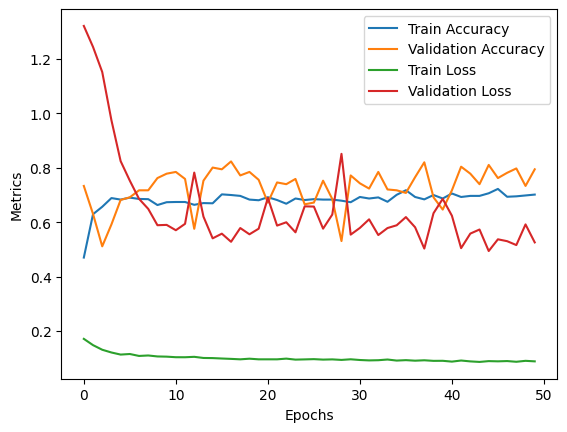

In [89]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [90]:
predicted_labels = np.array(predicted_labels)
rain_val_c_mod = np.array(rain_val_c_mod)

# Create DataFrame
pred_df = pd.DataFrame({'actual': rain_val_c_mod.flatten(), 'predicted': predicted_labels.flatten()})

# Check if predictions are correct
pred_df['Predictions_correct'] = (pred_df['predicted'] == pred_df['actual'])

# Display the DataFrame
print(pred_df)


      actual  predicted  Predictions_correct
0        1.0          1                 True
1        0.0          1                False
2        0.0          0                 True
3        0.0          0                 True
4        0.0          1                False
...      ...        ...                  ...
1239     0.0          0                 True
1240     1.0          1                 True
1241     0.0          1                False
1242     0.0          0                 True
1243     0.0          0                 True

[1244 rows x 3 columns]


In [91]:
pred_df[pred_df['actual'] == 0].value_counts()

actual  predicted  Predictions_correct
0.0     0          True                   562
        1          False                  371
Name: count, dtype: int64

In [92]:
pred_df[pred_df['actual'] == 1].value_counts()

actual  predicted  Predictions_correct
1.0     1          True                   309
        0          False                    2
Name: count, dtype: int64

In [93]:
pred_df[pred_df['actual'] == 2].value_counts()

Series([], Name: count, dtype: int64)

In [94]:
pred_df[pred_df['actual'] == 3].value_counts()

Series([], Name: count, dtype: int64)

### Confusion Matrix Analysis For test Data

The confusion matrix is a tool used to assess the performance of a classification algorithm. It compares the actual target values with those predicted by the model.

Here is the breakdown of the confusion matrix from the image:

- **True Labels vs Predicted Labels**: The matrix has four categories - None, Low, Medium, High. These represent the classification categories for the data.

- **Counts in the Matrix**:
  - `None` was correctly predicted 221 times but was incorrectly predicted as `Low` 42 times.
  - `Low` was correctly predicted 26 times, and incorrectly predicted as `None` 18 times.
  - `Medium` and `High` had no correct predictions and were predicted as `None` 3 and 1 times, respectively.
  - There were no instances of `Medium` or `High` being predicted as any class.

- **Observations**:
  - The model is quite accurate in predicting the `None` class but confuses it with `Low` sometimes.
  - `Low` predictions are less accurate than `None`, with a significant number of instances confused with `None`.
  - The model fails to predict `Medium` and `High` categories altogether.


This matrix indicates that the model is skewed towards predicting the `None` category well but performs poorly on other categories, particularly `Medium` and `High`.


10/10 [==============================] - 2s 207ms/step


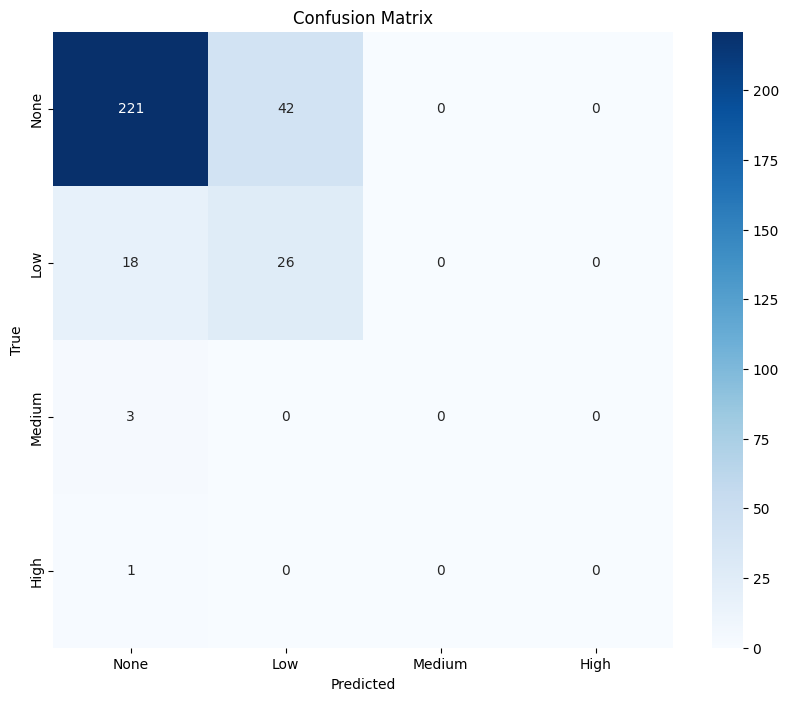

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation set
predictions = model_lstm_ml.predict([meteo_val, cloud_val])
predicted_classes = np.argmax(predictions, axis=-1)

# Get the true classes from rain_val_c_mod
true_classes = np.argmax(rain_val_c_mod, axis=-1)  # Decode one-hot encoded labels

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['None', 'Low', 'Medium', 'High'], yticklabels=['None', 'Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Confusion Matrix for Training Data Analysis

A confusion matrix is a visualization tool typically used to measure the performance of a machine learning classification model. The rows represent the actual class labels of the data, while the columns represent the predicted class labels by the model.

Here's the breakdown of the confusion matrix for the training data depicted in the image:

- **True Labels vs Predicted Labels**: The matrix has four categories - None, Low, Medium, High - which are the classes into which the data points are classified.

- **Counts in the Matrix**:
  - `None` was correctly predicted 826 times but was incorrectly predicted as `Low` 233 times.
  - `Low` was correctly predicted 109 times, but was incorrectly predicted as `None` 63 times.
  - `Medium` was correctly predicted 7 times, but was incorrectly predicted as `None` 7 times.
  - `High` did not have any correct predictions and was incorrectly predicted as `None` 2 times.

- **Observations**:
  - The model has a strong ability to predict the `None` class correctly, although it has a considerable number of false positives where it predicts `Low` when it is actually `None`.
  - For the `Low` class, the model demonstrates moderate performance but still misclassifies several instances as `None`.
  - The `Medium` and `High` classes have very few instances and the model does not predict any data points as `Medium` or `High`. It tends to misclassify these classes as `None`.

This matrix indicates that while the model is most accurate with the `None` category, its ability to distinguish between the `Low`, `Medium`, and `High` categories, especially the latter two, needs improvement.


40/40 [==============================] - 7s 183ms/step


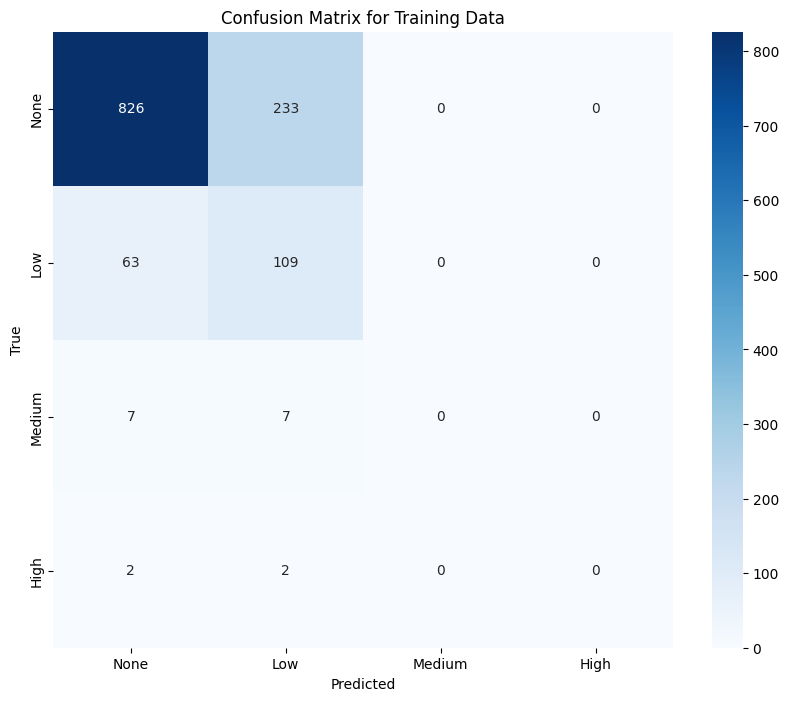

In [96]:
# Make predictions on the training set
train_predictions = model_lstm_ml.predict([meteo_train, cloud_train])
train_predicted_classes = np.argmax(train_predictions, axis=-1)

# Get the true classes from rain_train_c_mod
train_true_classes = np.argmax(rain_train_c_mod, axis=-1)  # Decode one-hot encoded labels

# Compute the confusion matrix for training data
train_cm = confusion_matrix(train_true_classes, train_predicted_classes)

# Plot the confusion matrix for training data
plt.figure(figsize=(10, 8))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['None', 'Low', 'Medium', 'High'], yticklabels=['None', 'Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Training Data')
plt.show()


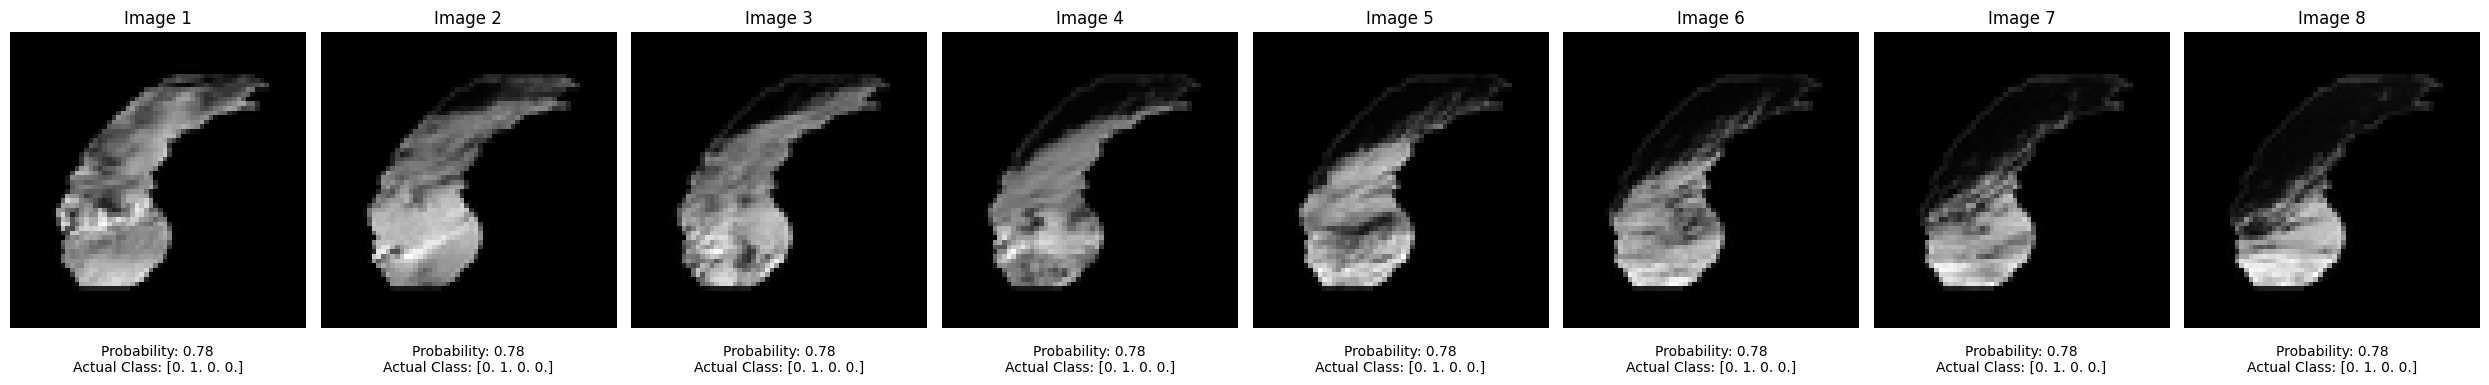

In [97]:
num_images = len(cloud_val[0]) #no of images in a single batch

fig, axes = plt.subplots(1, num_images, figsize=(25, 5))

for i, ax in enumerate(axes):
    # Display the image
    ax.imshow(cloud_val[3][i][:, :, 0], cmap='gray')  
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')  # Turn off axis
    
    # Extract the predicted probability and actual class for the i-th image
    probability = predictions[3][0]  
    actual_class = rain_val_c_mod[3]  
    
    ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
            transform=ax.transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.show()

**Plot the images for Reference**

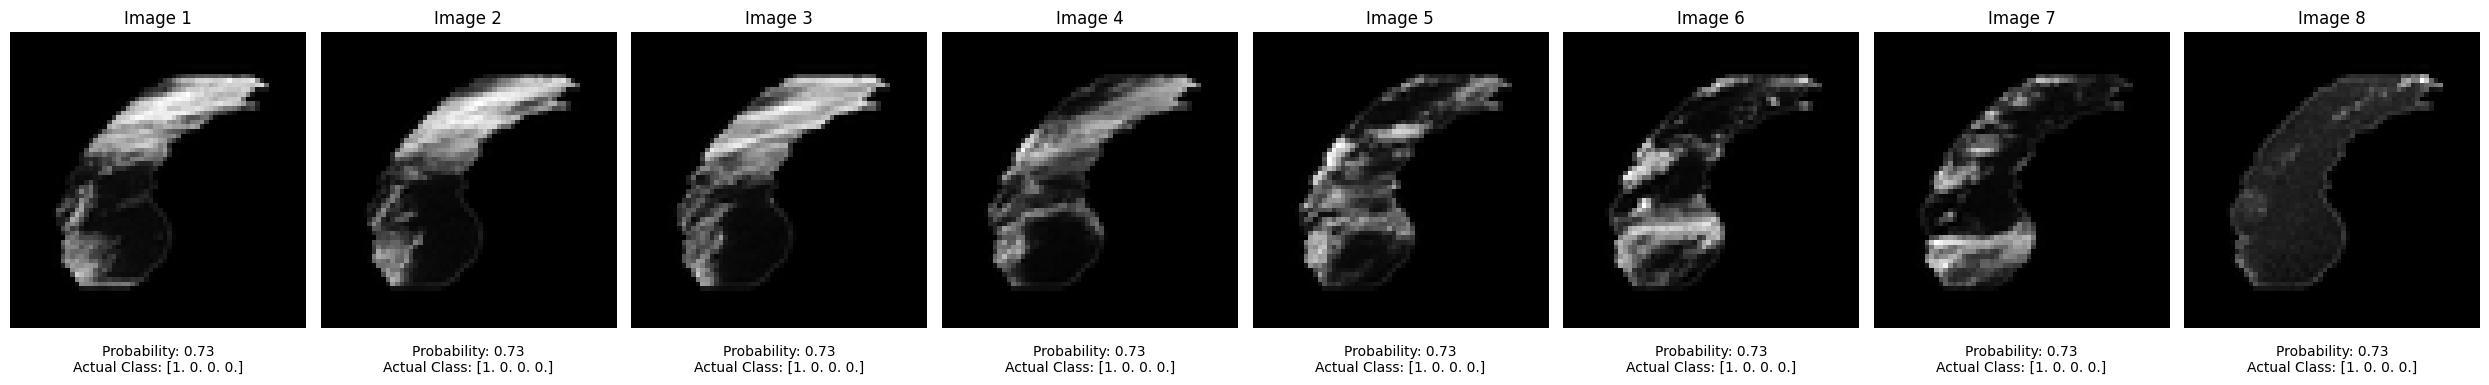

In [73]:
num_images = len(cloud_val[1]) #no of images in a single batch

fig, axes = plt.subplots(1, num_images, figsize=(25, 5))

for i, ax in enumerate(axes):
    # Display the image
    ax.imshow(cloud_val[4][i][:, :, 0], cmap='gray')  
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')  # Turn off axis
    
    probability = predictions[4][0]  
    actual_class = rain_val_c_mod[4]  
    
    ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
            transform=ax.transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.show()

**Load the model**

In [98]:
from tensorflow.keras.models import load_model

model = load_model('multiclass_deep_model.h5')


In [99]:
from sklearn.metrics import classification_report

predictions = model.predict([meteo_val, cloud_val])

predicted_labels = (predictions > 0.5).astype(int)

# print(classification_report(rain_val_c_mod, predicted_labels))

10/10 [==============================] - 3s 165ms/step


**Predicting for 3 days**

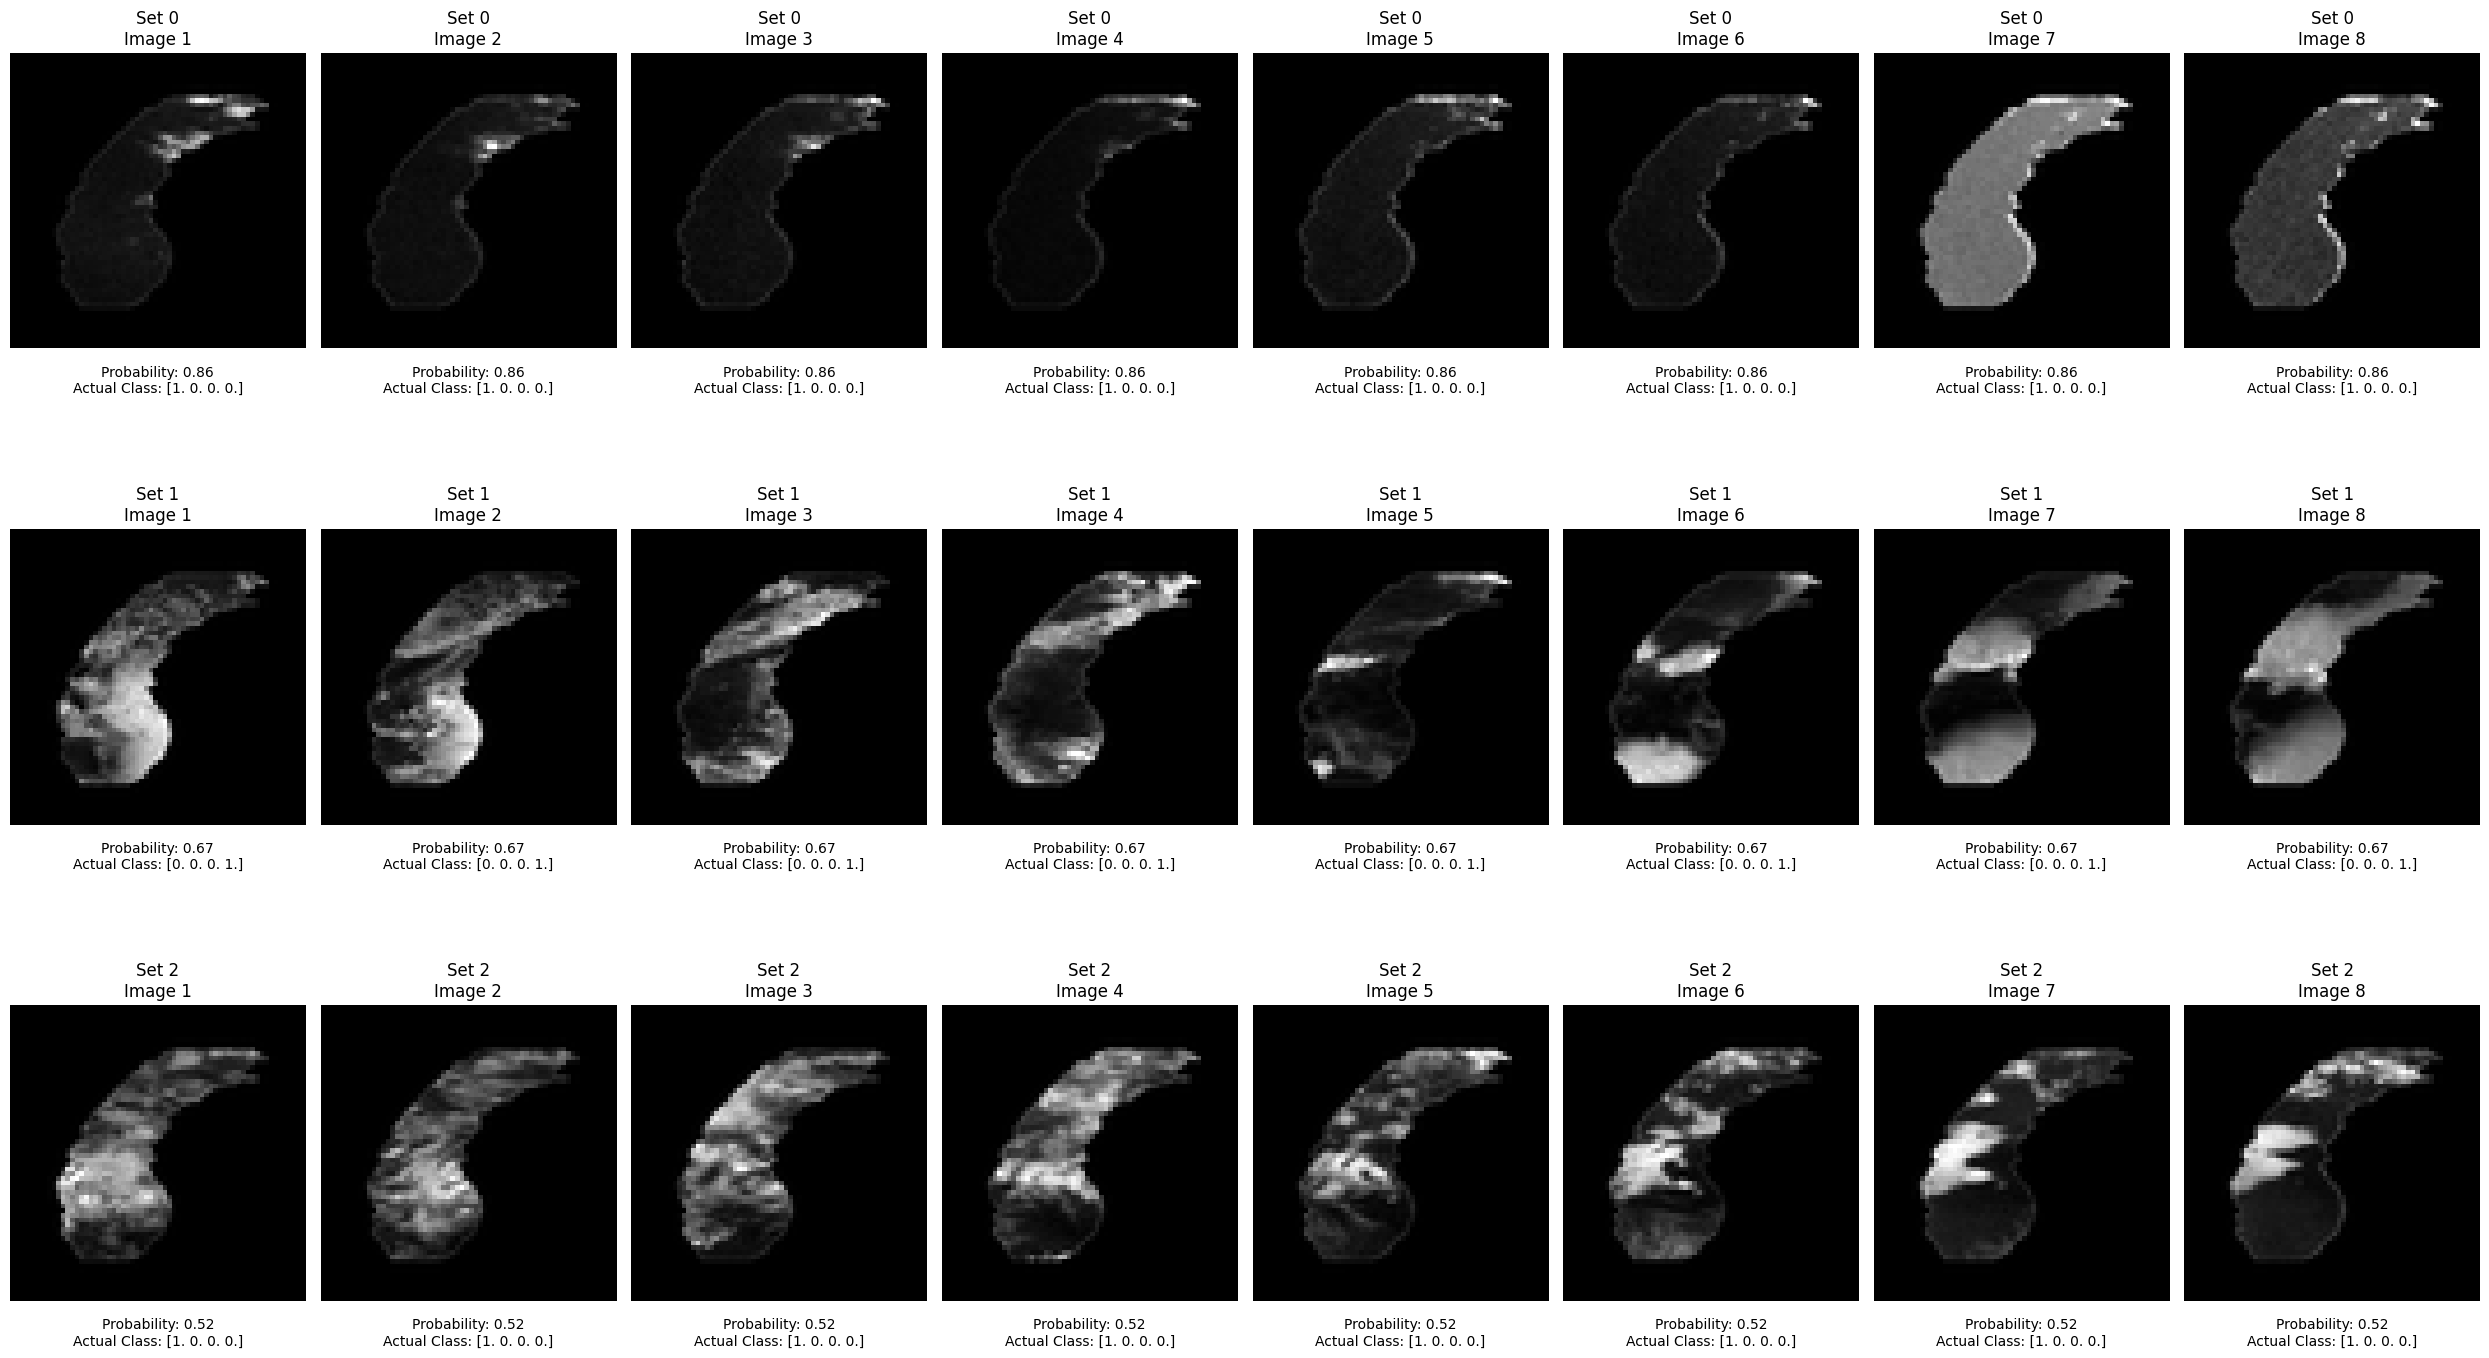

In [100]:
num_sets = 3  
num_images_per_set = 8 

fig, axes = plt.subplots(num_sets, num_images_per_set, figsize=(25, 5 * num_sets))

for set_idx in range(num_sets):
    for i in range(num_images_per_set):
        # Calculate the index in the dataset based on the set index
        
        # Display the image
        ax = axes[set_idx, i]
        ax.imshow(cloud_val[set_idx][i][:, :, 0], cmap='gray')  
        ax.set_title(f'Set {set_idx}\nImage {i + 1}')
        ax.axis('off')  # Turn off axis
        
        probability = predictions[set_idx][0]  
        actual_class = rain_val_c_mod[set_idx] 
    
        ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
                transform=ax.transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.show()

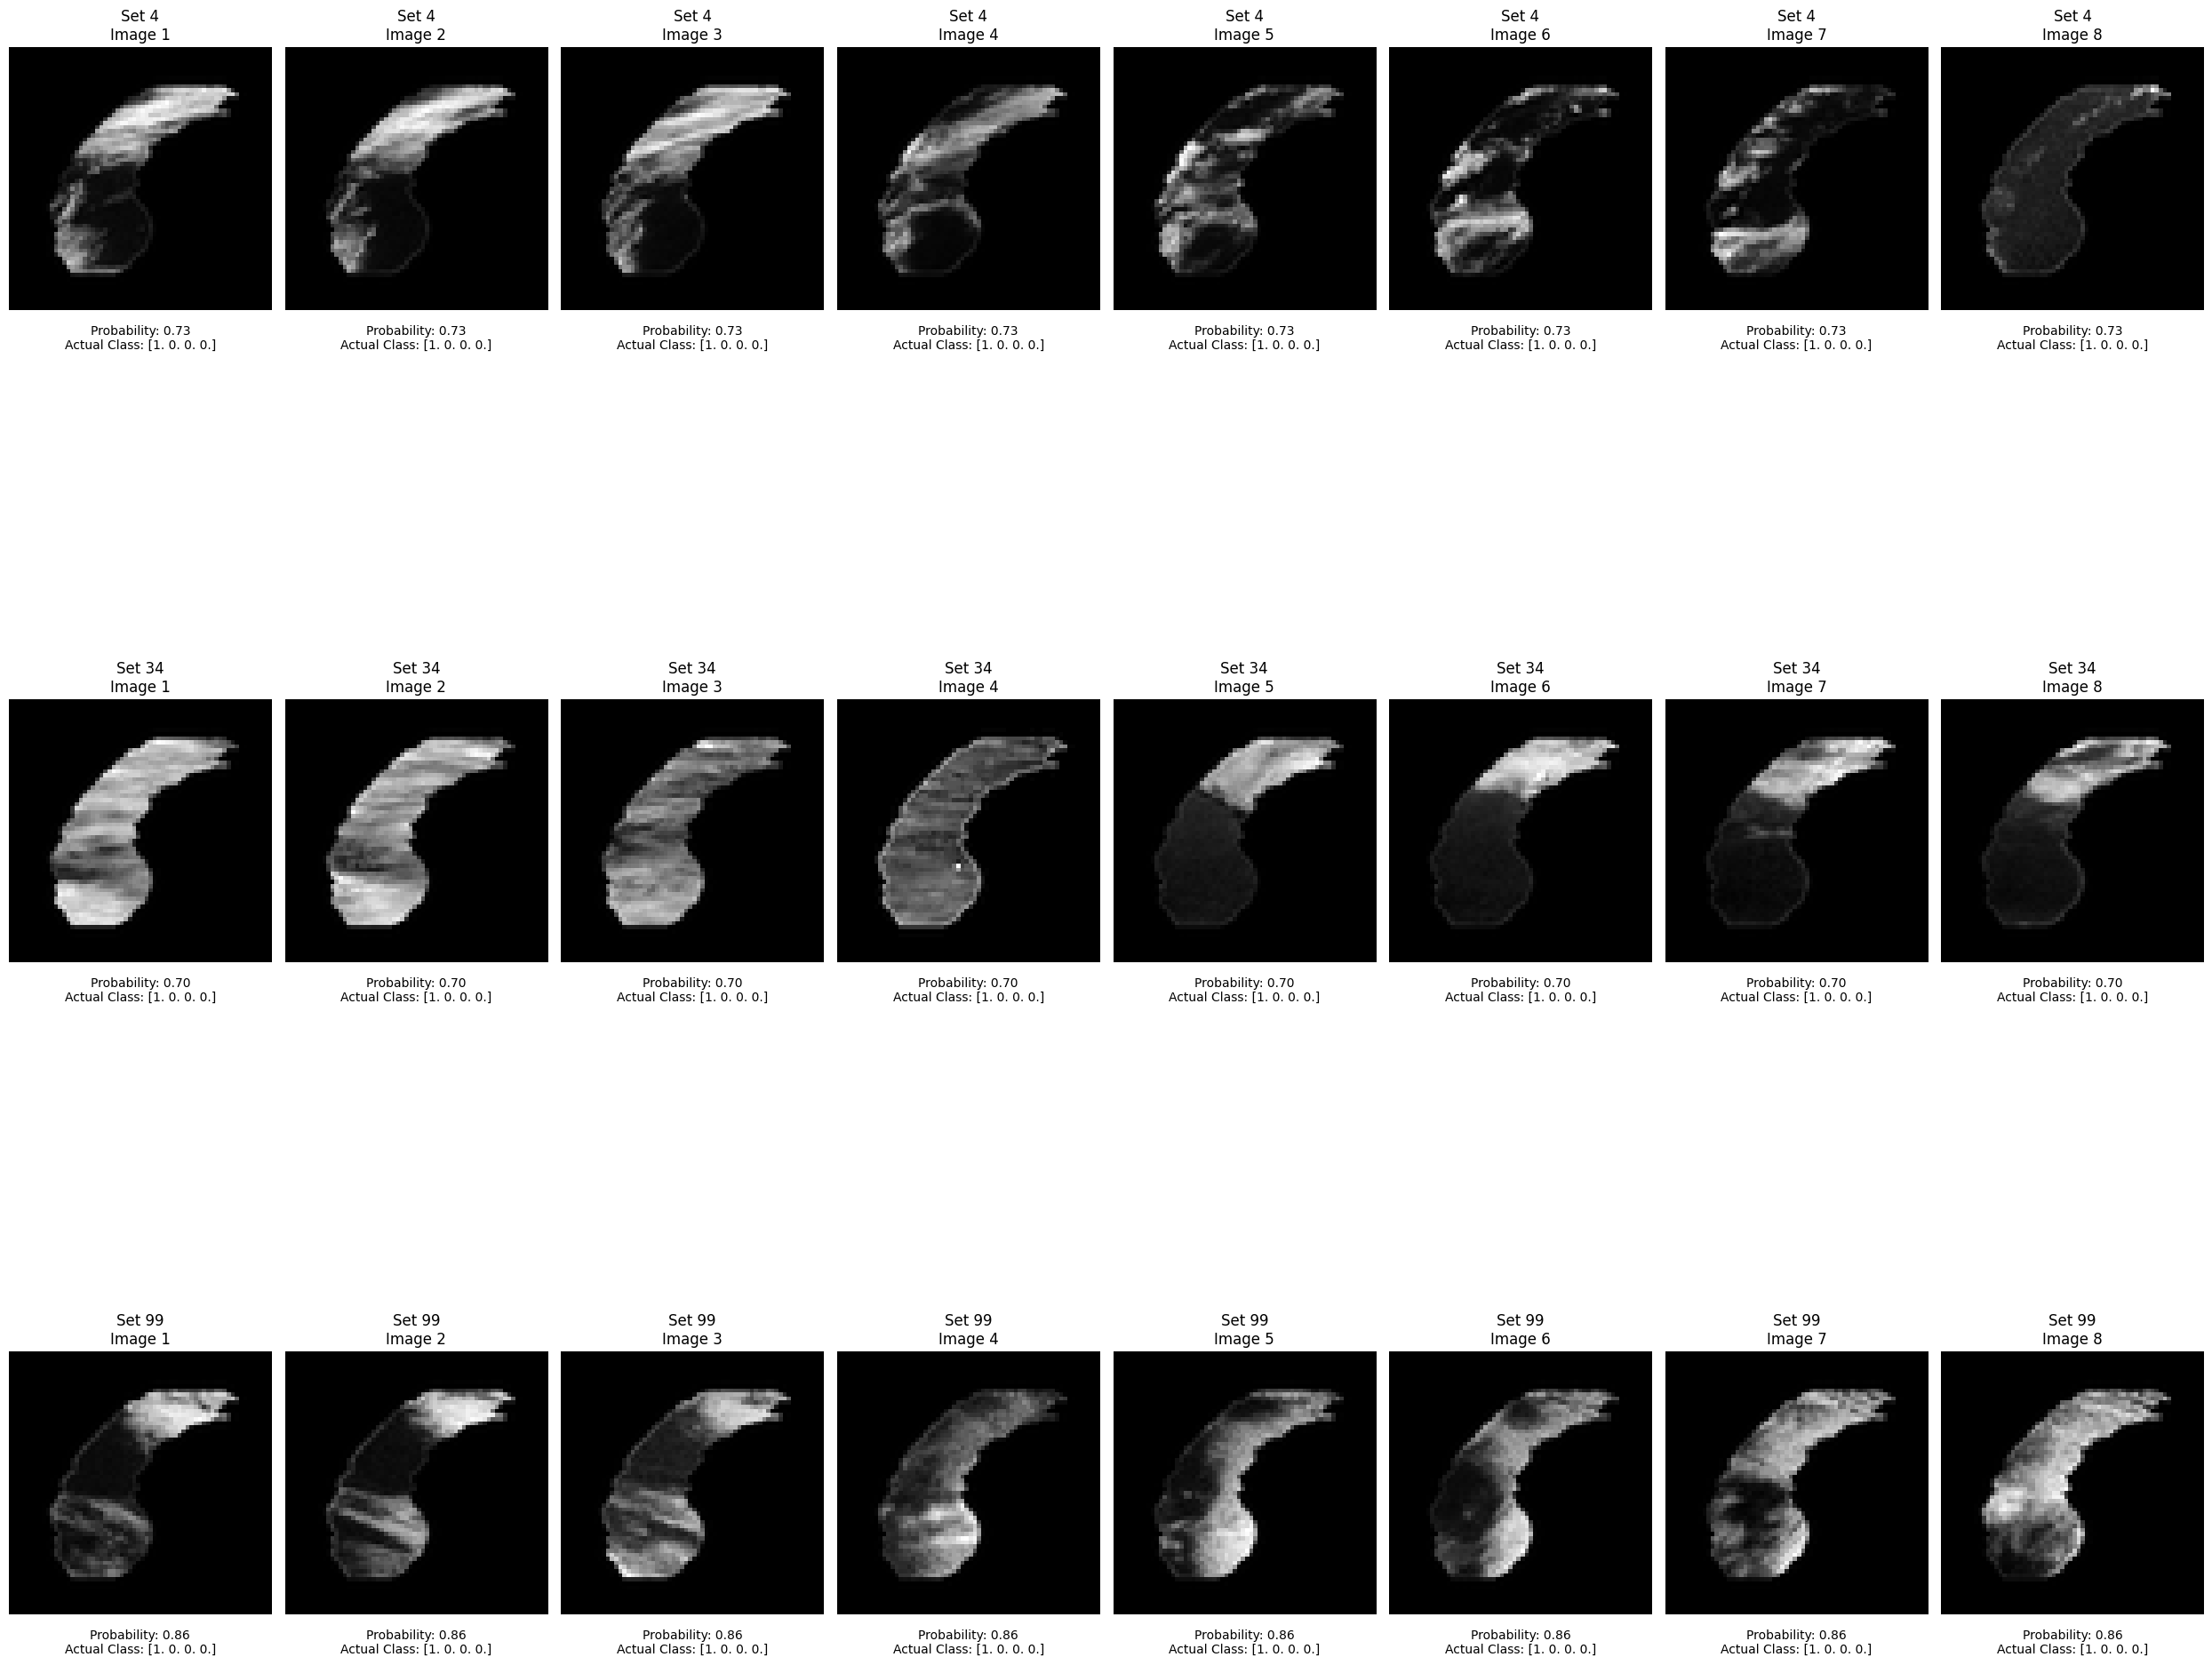

In [101]:
num_sets = [4, 34, 99] 
num_images_per_set = 8 

fig, axes = plt.subplots(3, num_images_per_set, figsize=(25, 5 * 5))
y=0
for set_idx in num_sets:
    for i in range(num_images_per_set):
        # Calculate the index in the dataset based on the set index
        
        # Display the image
        ax = axes[y, i]
        ax.imshow(cloud_val[set_idx][i][:, :, 0], cmap='gray')  
        ax.set_title(f'Set {set_idx}\nImage {i + 1}')
        ax.axis('off')  # Turn off axis
        
        probability = predictions[set_idx][0]  
        actual_class = rain_val_c_mod[set_idx] 
    
        ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
                transform=ax.transAxes, fontsize=10, ha='center')
    y+=1
plt.tight_layout()
plt.show()

**Predicting for 5 days**

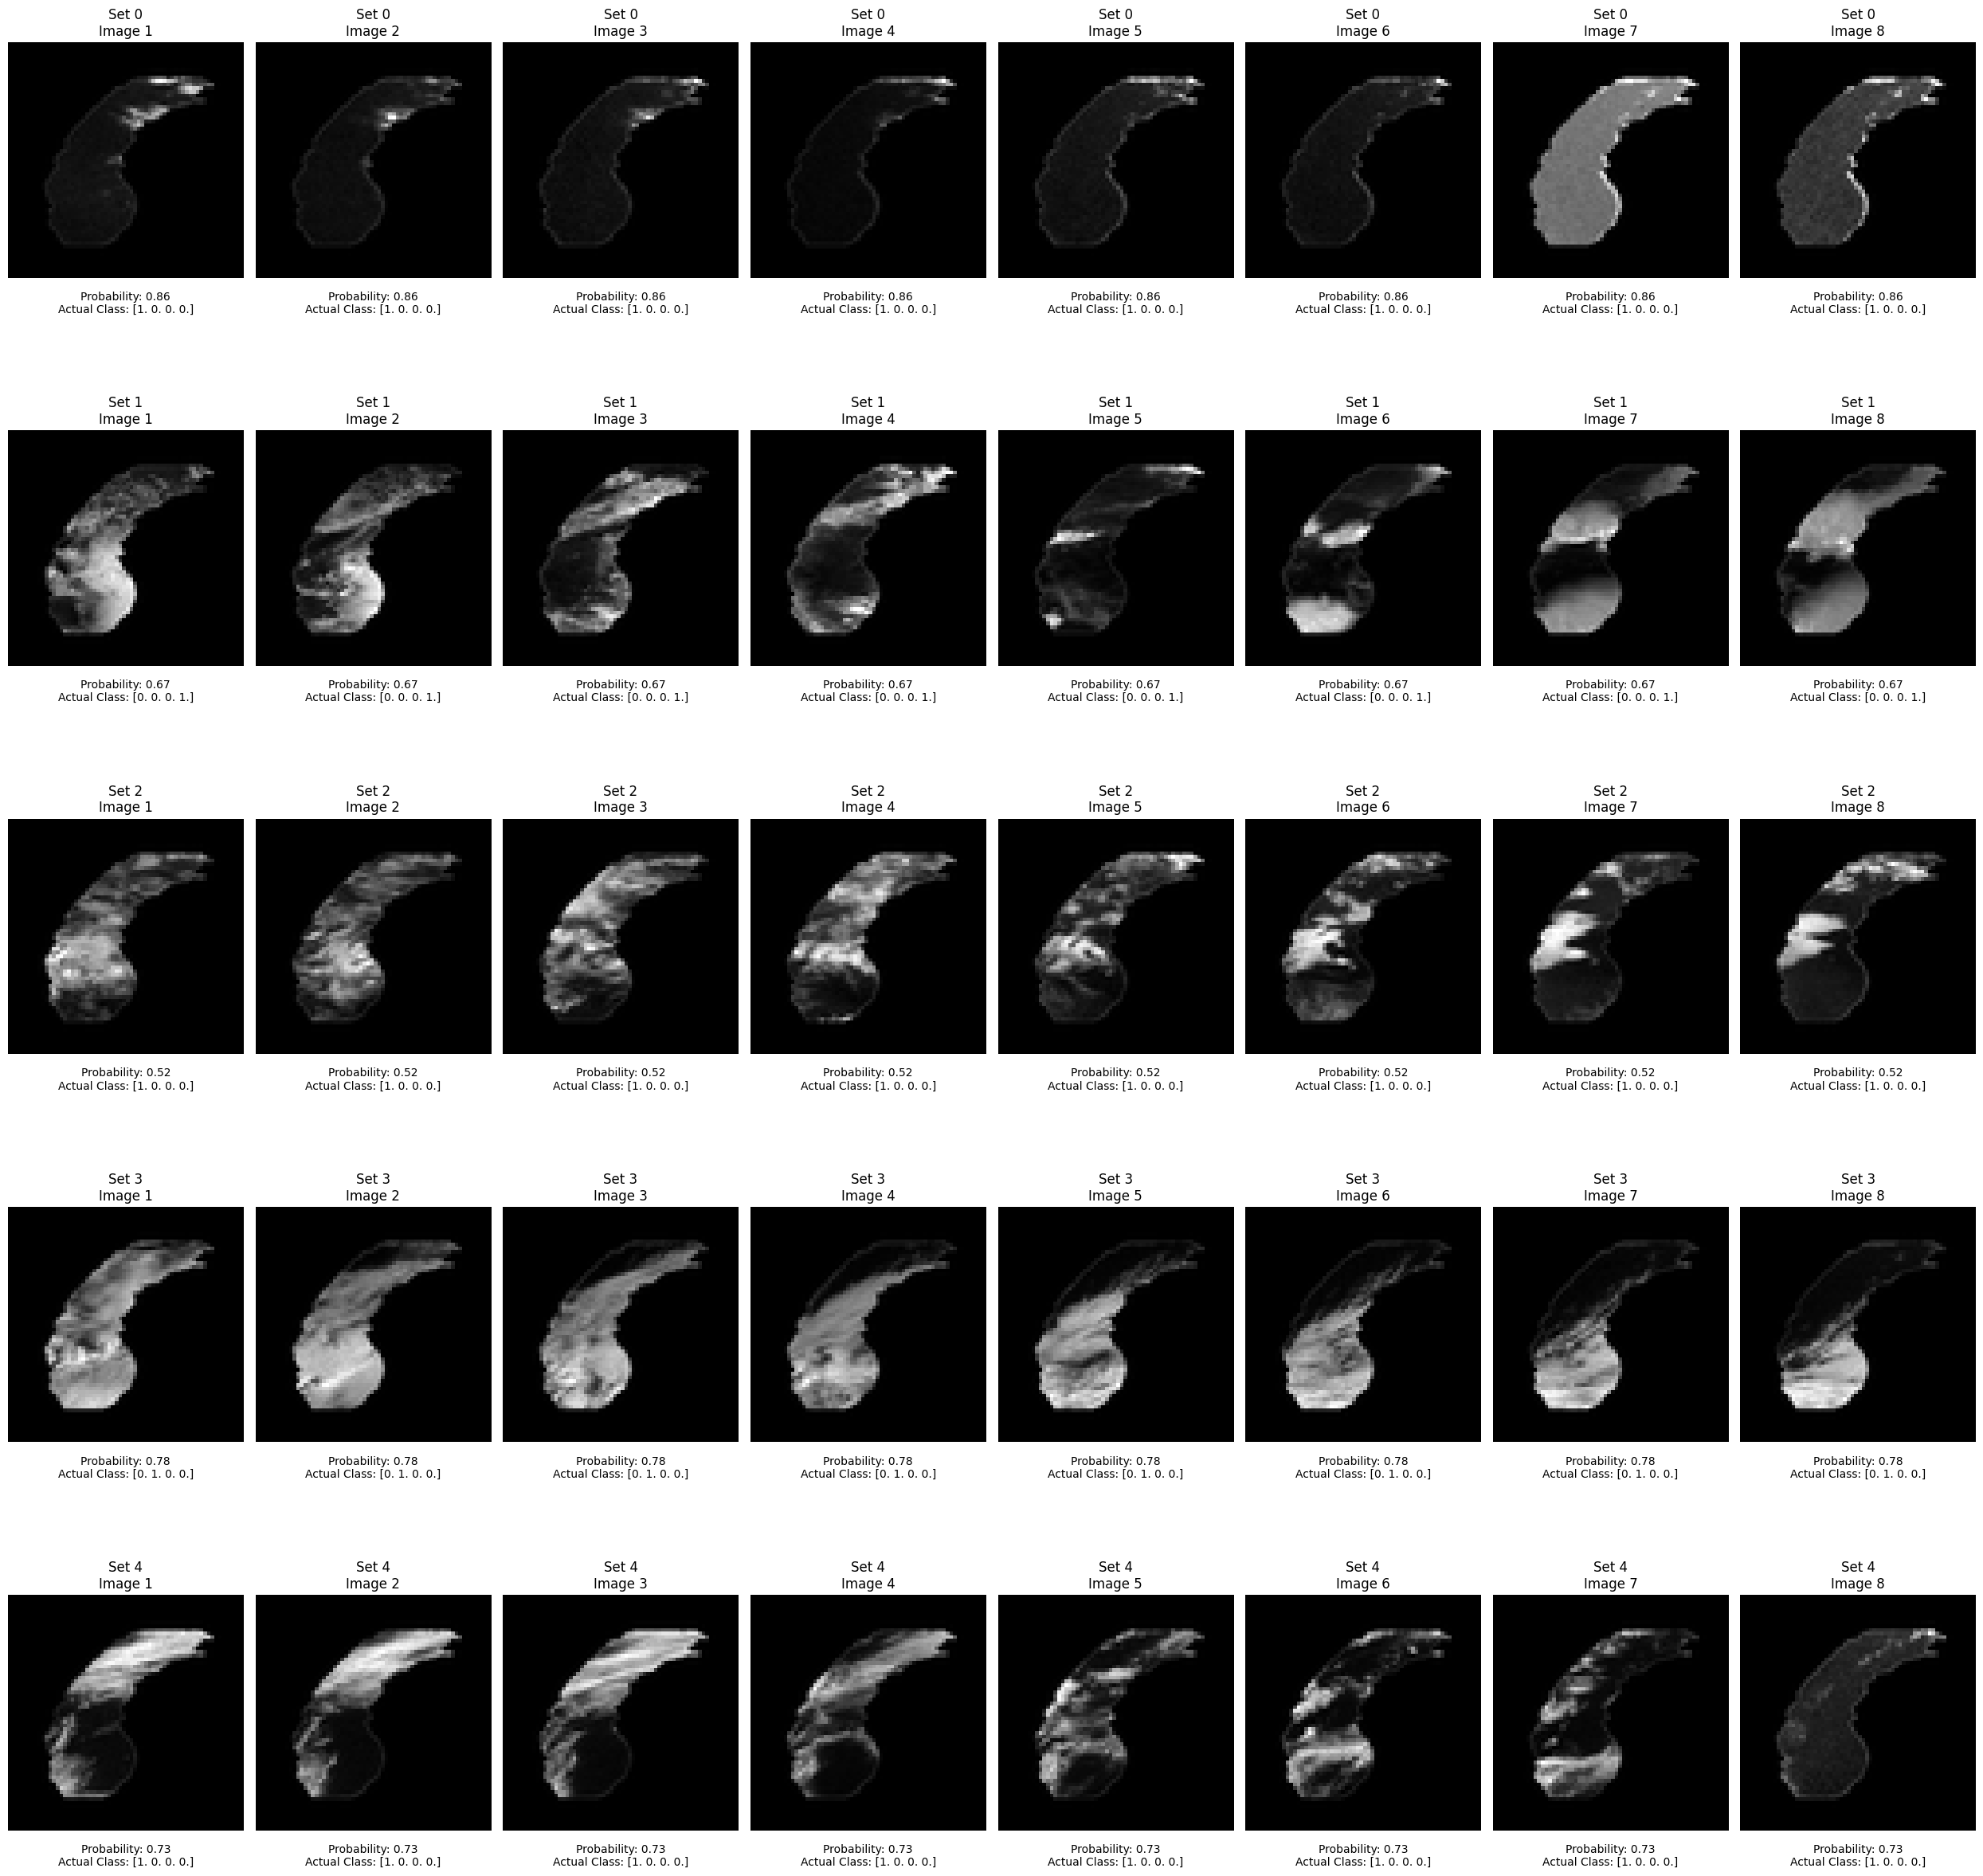

In [102]:
num_sets = 5  
num_images_per_set = 8 

fig, axes = plt.subplots(num_sets, num_images_per_set, figsize=(25, 5 * num_sets))

for set_idx in range(num_sets):
    for i in range(num_images_per_set):
        # Calculate the index in the dataset based on the set index
        
        # Display the image
        ax = axes[set_idx, i]
        ax.imshow(cloud_val[set_idx][i][:, :, 0], cmap='gray')  
        ax.set_title(f'Set {set_idx}\nImage {i + 1}')
        ax.axis('off')  # Turn off axis
        
        probability = predictions[set_idx][0]  
        actual_class = rain_val_c_mod[set_idx] 
    
        ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
                transform=ax.transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.show()

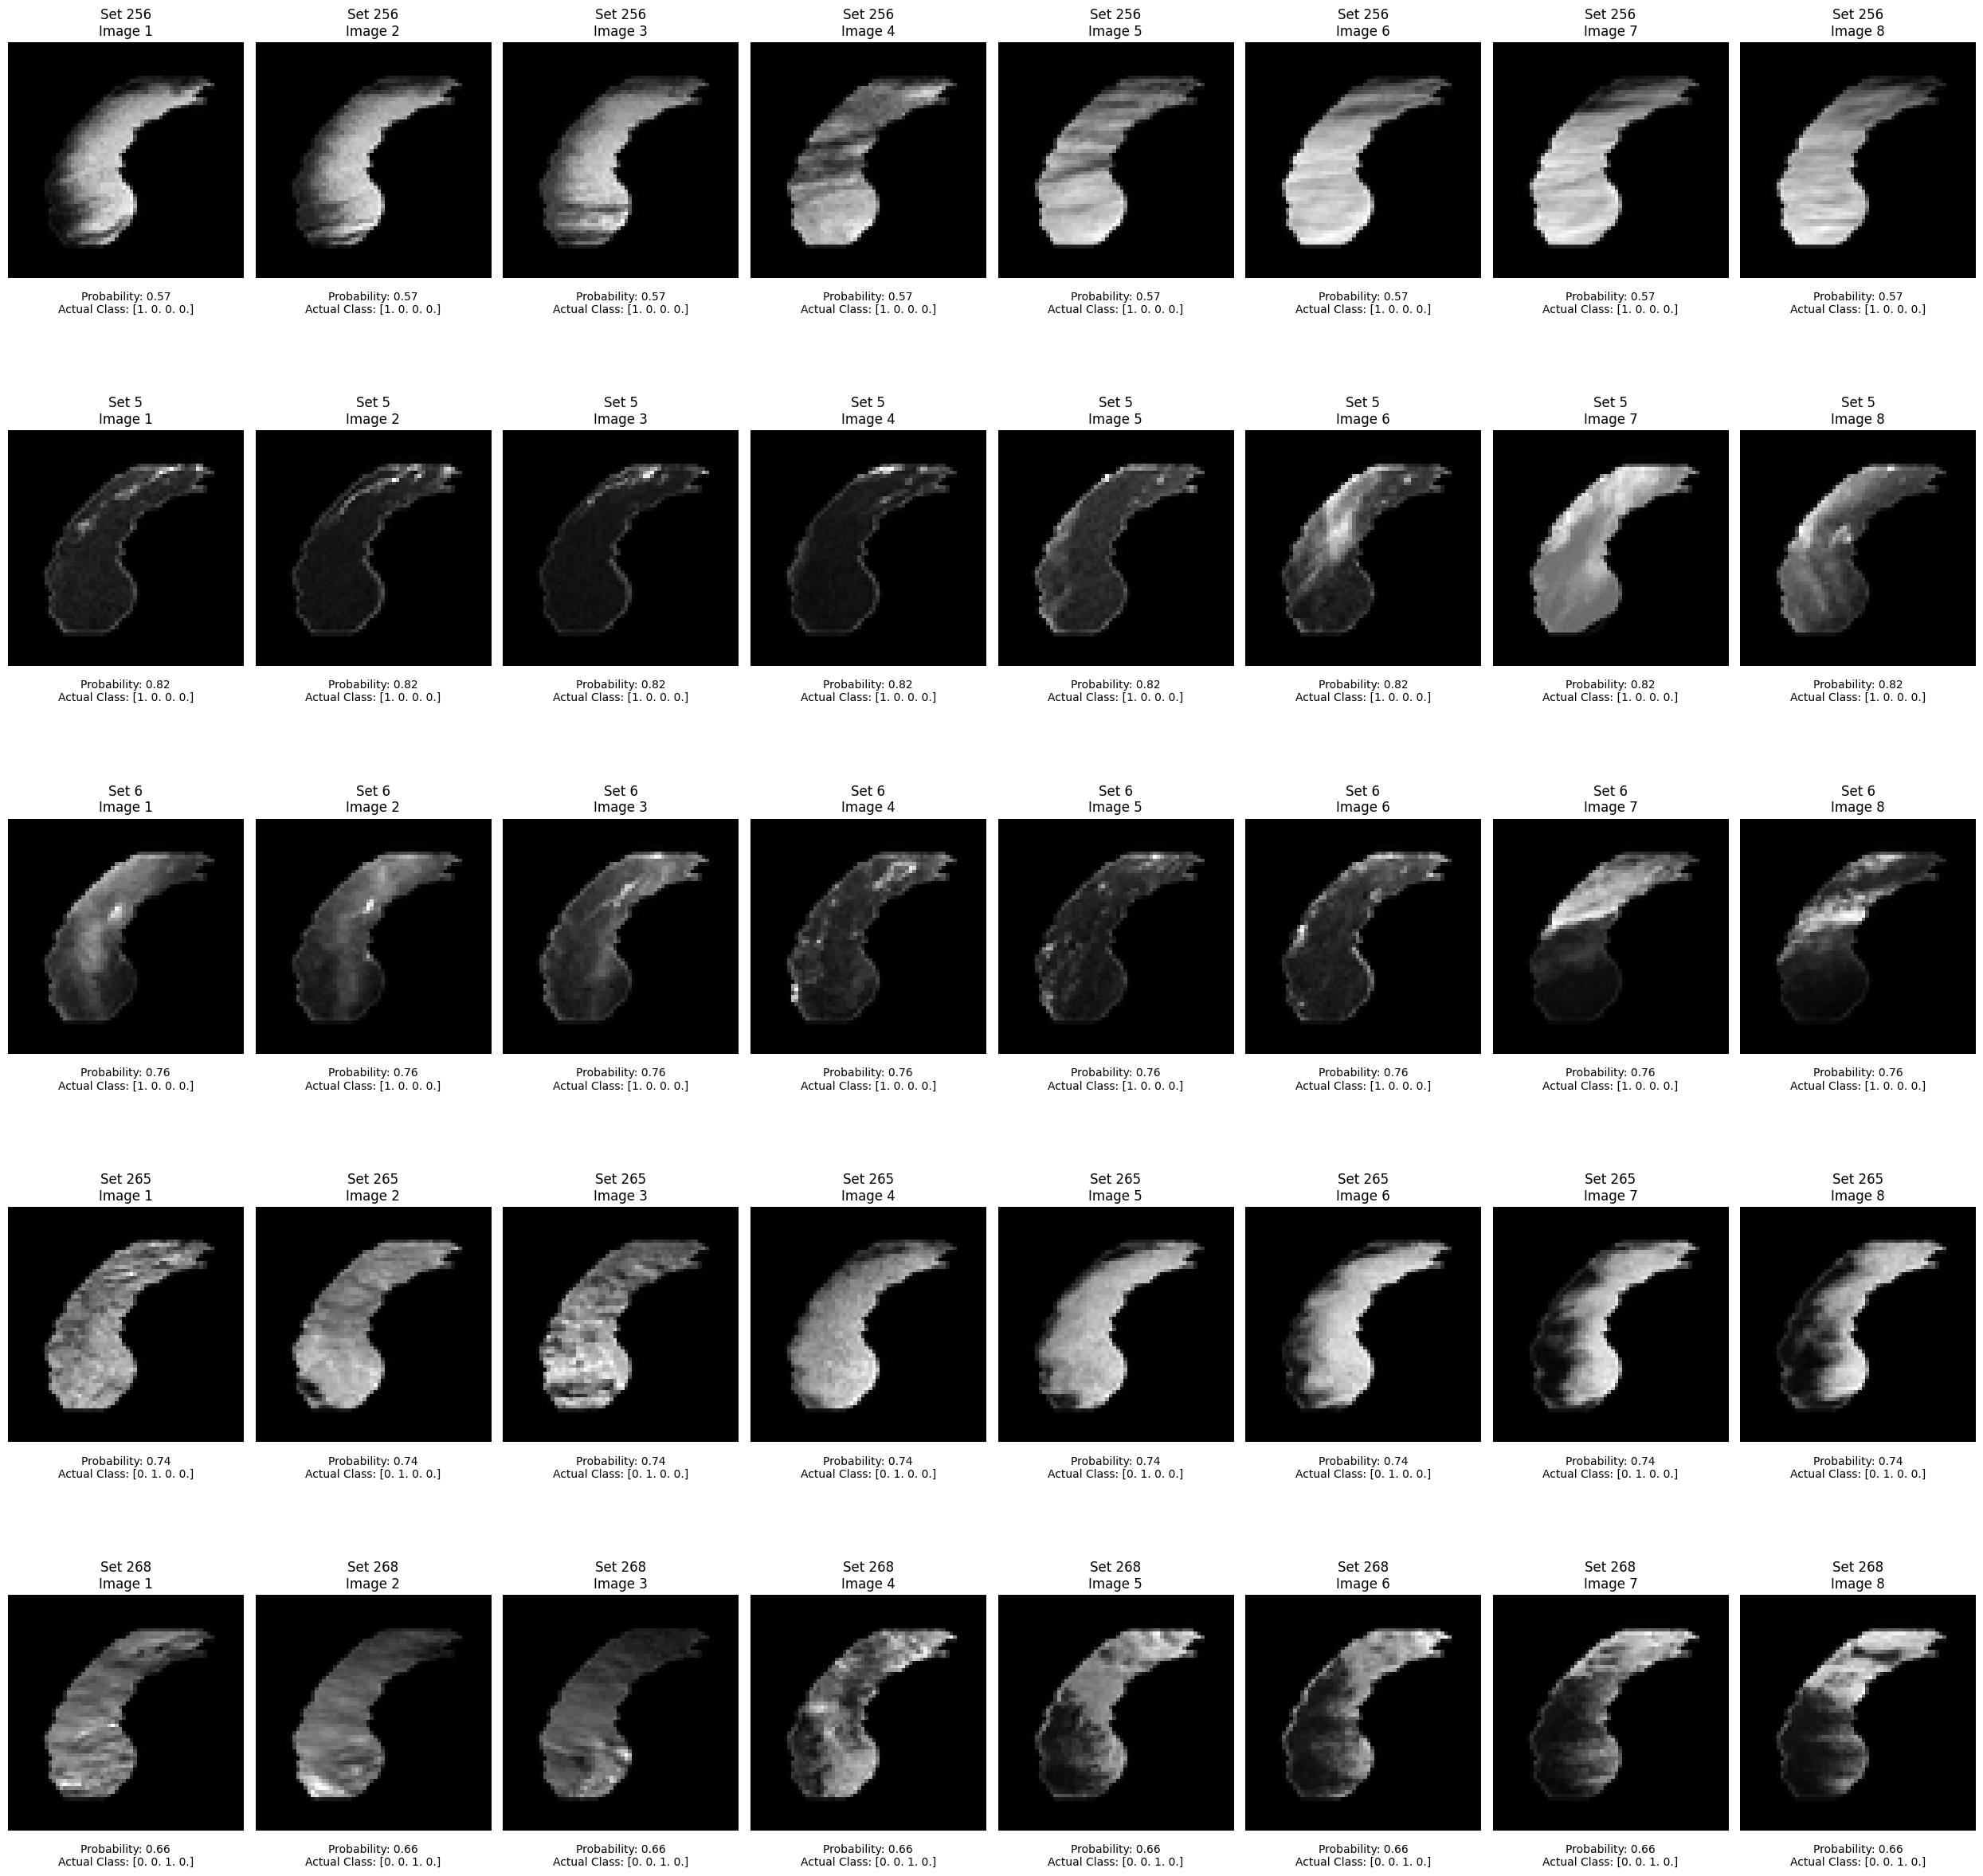

In [103]:
num_sets = [256, 5, 6, 265, 268] 
num_images_per_set = 8 

fig, axes = plt.subplots(5, num_images_per_set, figsize=(25, 5 * 5))
y=0
for set_idx in num_sets:
    for i in range(num_images_per_set):
        # Calculate the index in the dataset based on the set index
        
        # Display the image
        ax = axes[y, i]
        ax.imshow(cloud_val[set_idx][i][:, :, 0], cmap='gray')  
        ax.set_title(f'Set {set_idx}\nImage {i + 1}')
        ax.axis('off')  # Turn off axis
        
        probability = predictions[set_idx][0]  
        actual_class = rain_val_c_mod[set_idx] 
    
        ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
                transform=ax.transAxes, fontsize=10, ha='center')
    y+=1
plt.tight_layout()
plt.show()

**Predicting for 7 days**

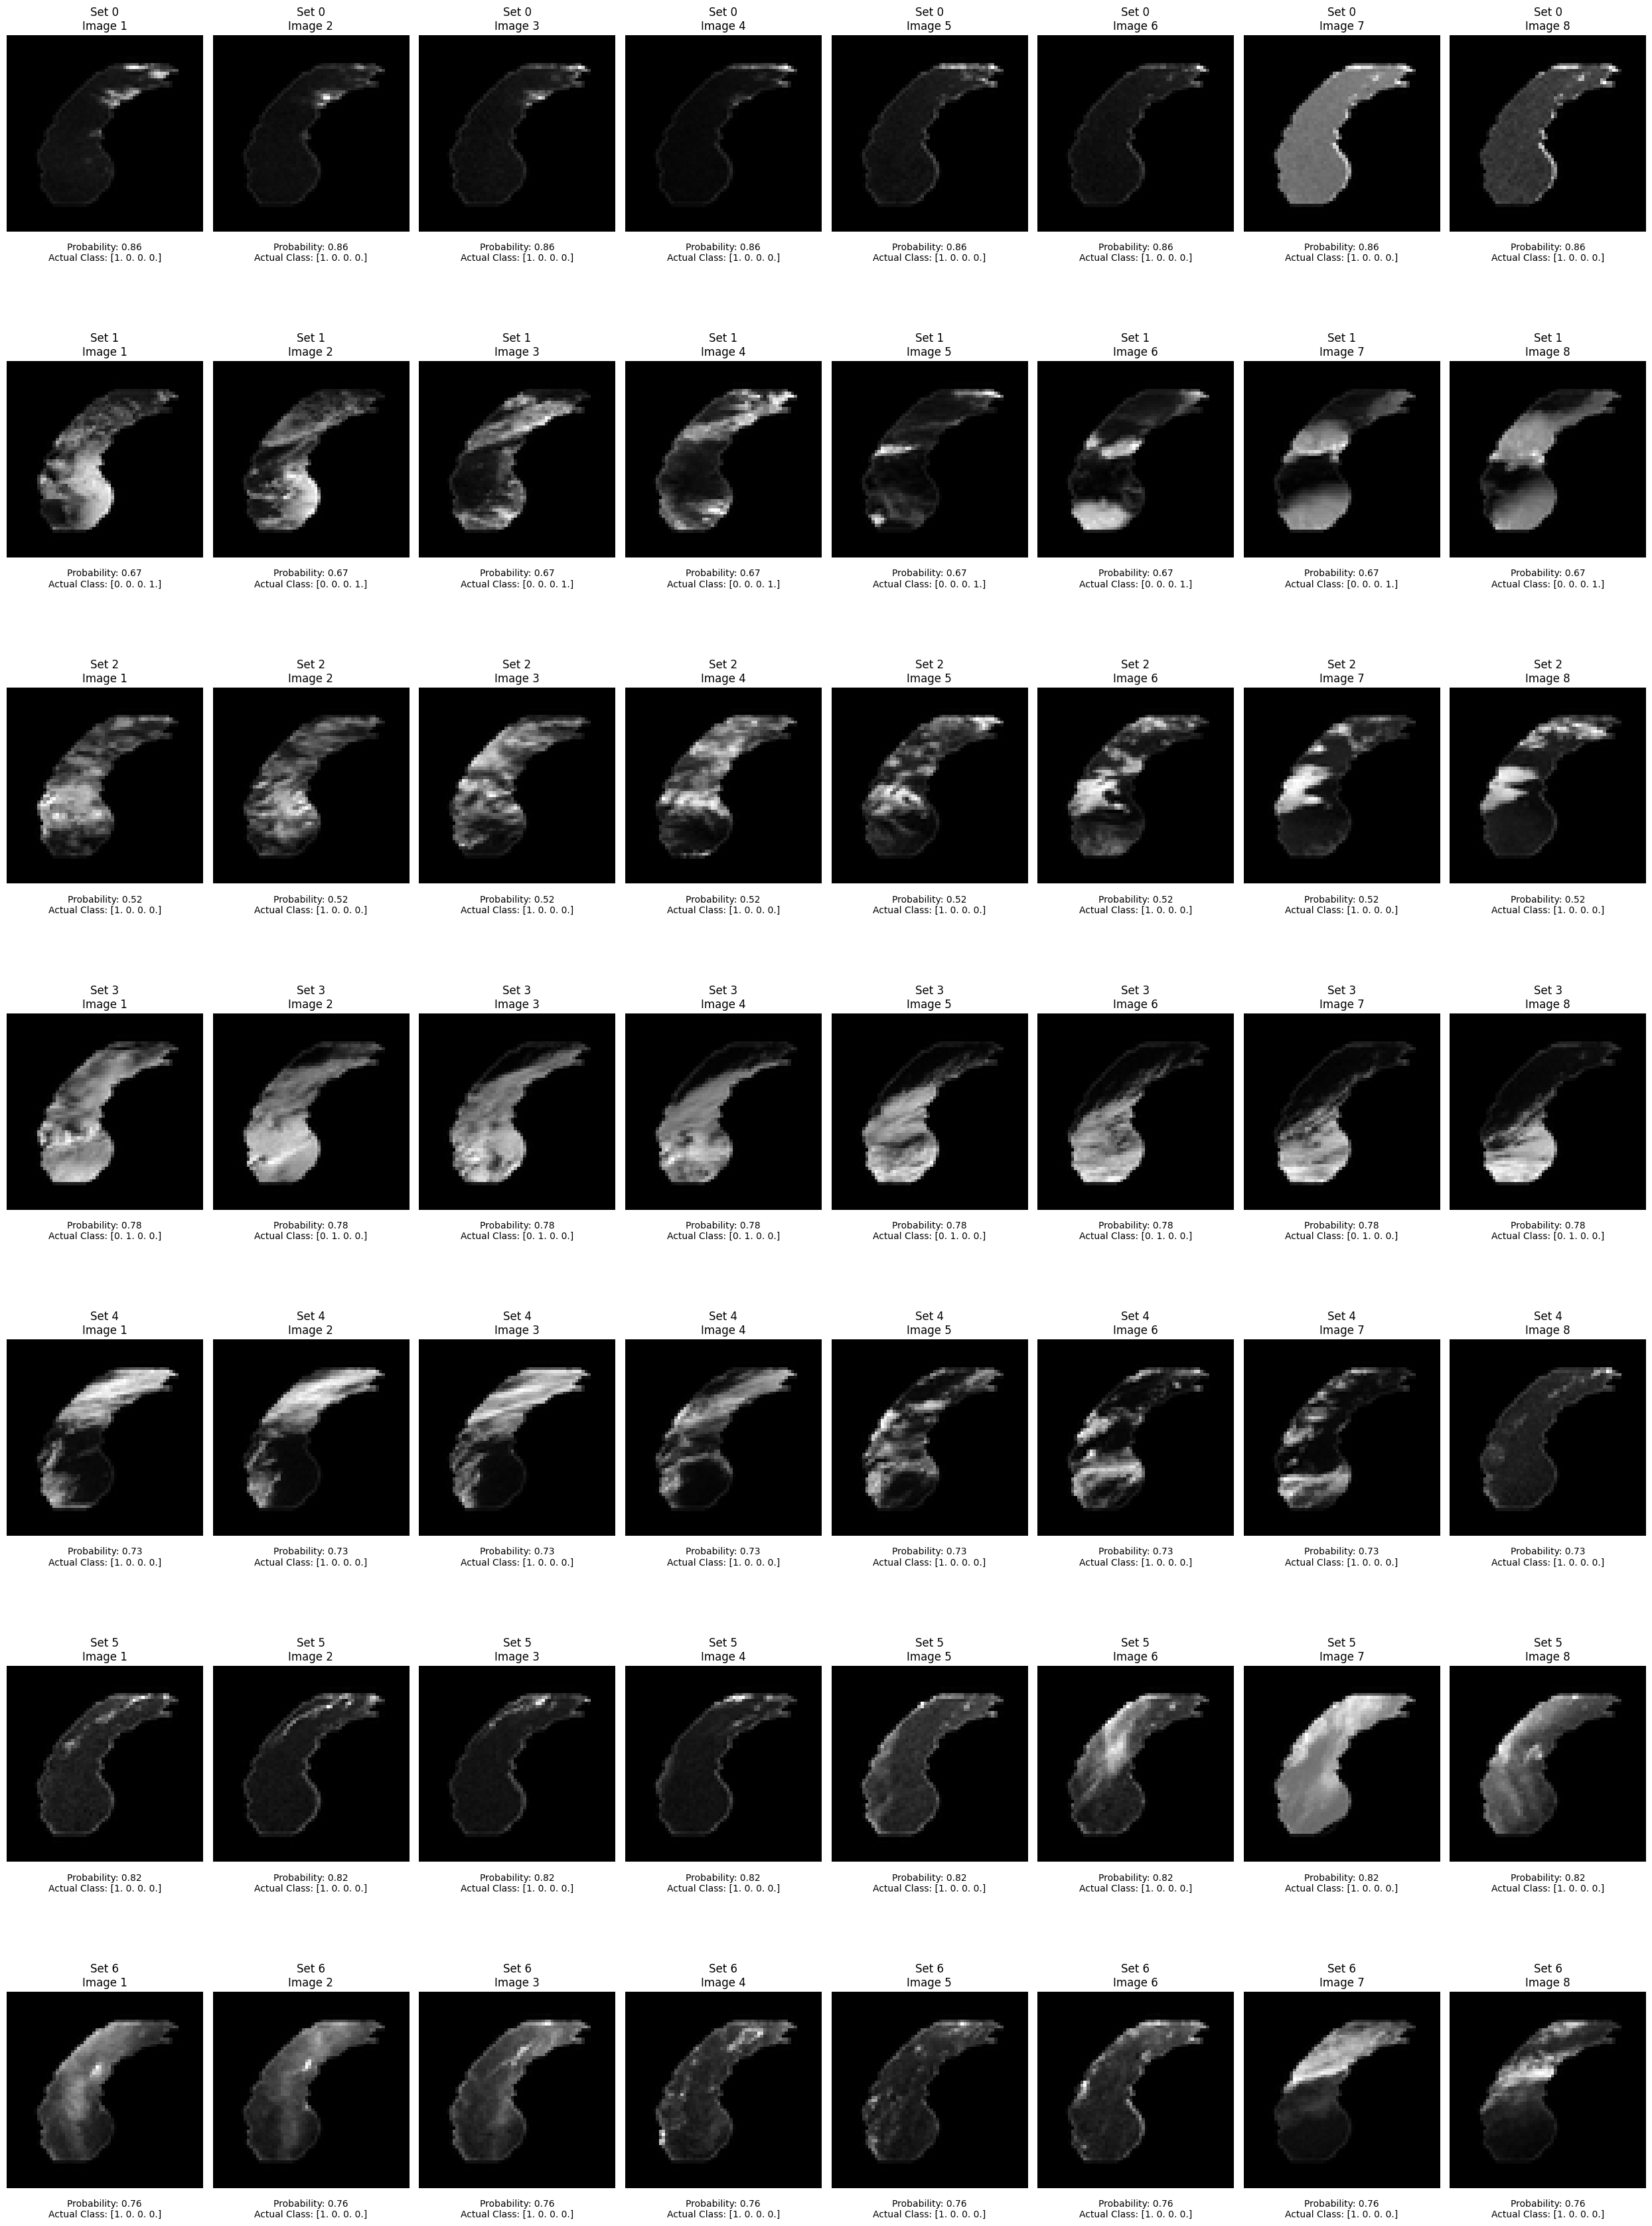

In [104]:
num_sets = 7  
num_images_per_set = 8 

fig, axes = plt.subplots(num_sets, num_images_per_set, figsize=(25, 5 * num_sets))

for set_idx in range(num_sets):
    for i in range(num_images_per_set):
        # Calculate the index in the dataset based on the set index
        
        # Display the image
        ax = axes[set_idx, i]
        ax.imshow(cloud_val[set_idx][i][:, :, 0], cmap='gray')  
        ax.set_title(f'Set {set_idx}\nImage {i + 1}')
        ax.axis('off')  # Turn off axis
        
        probability = predictions[set_idx][0]  
        actual_class = rain_val_c_mod[set_idx] 
    
        ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
                transform=ax.transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.show()

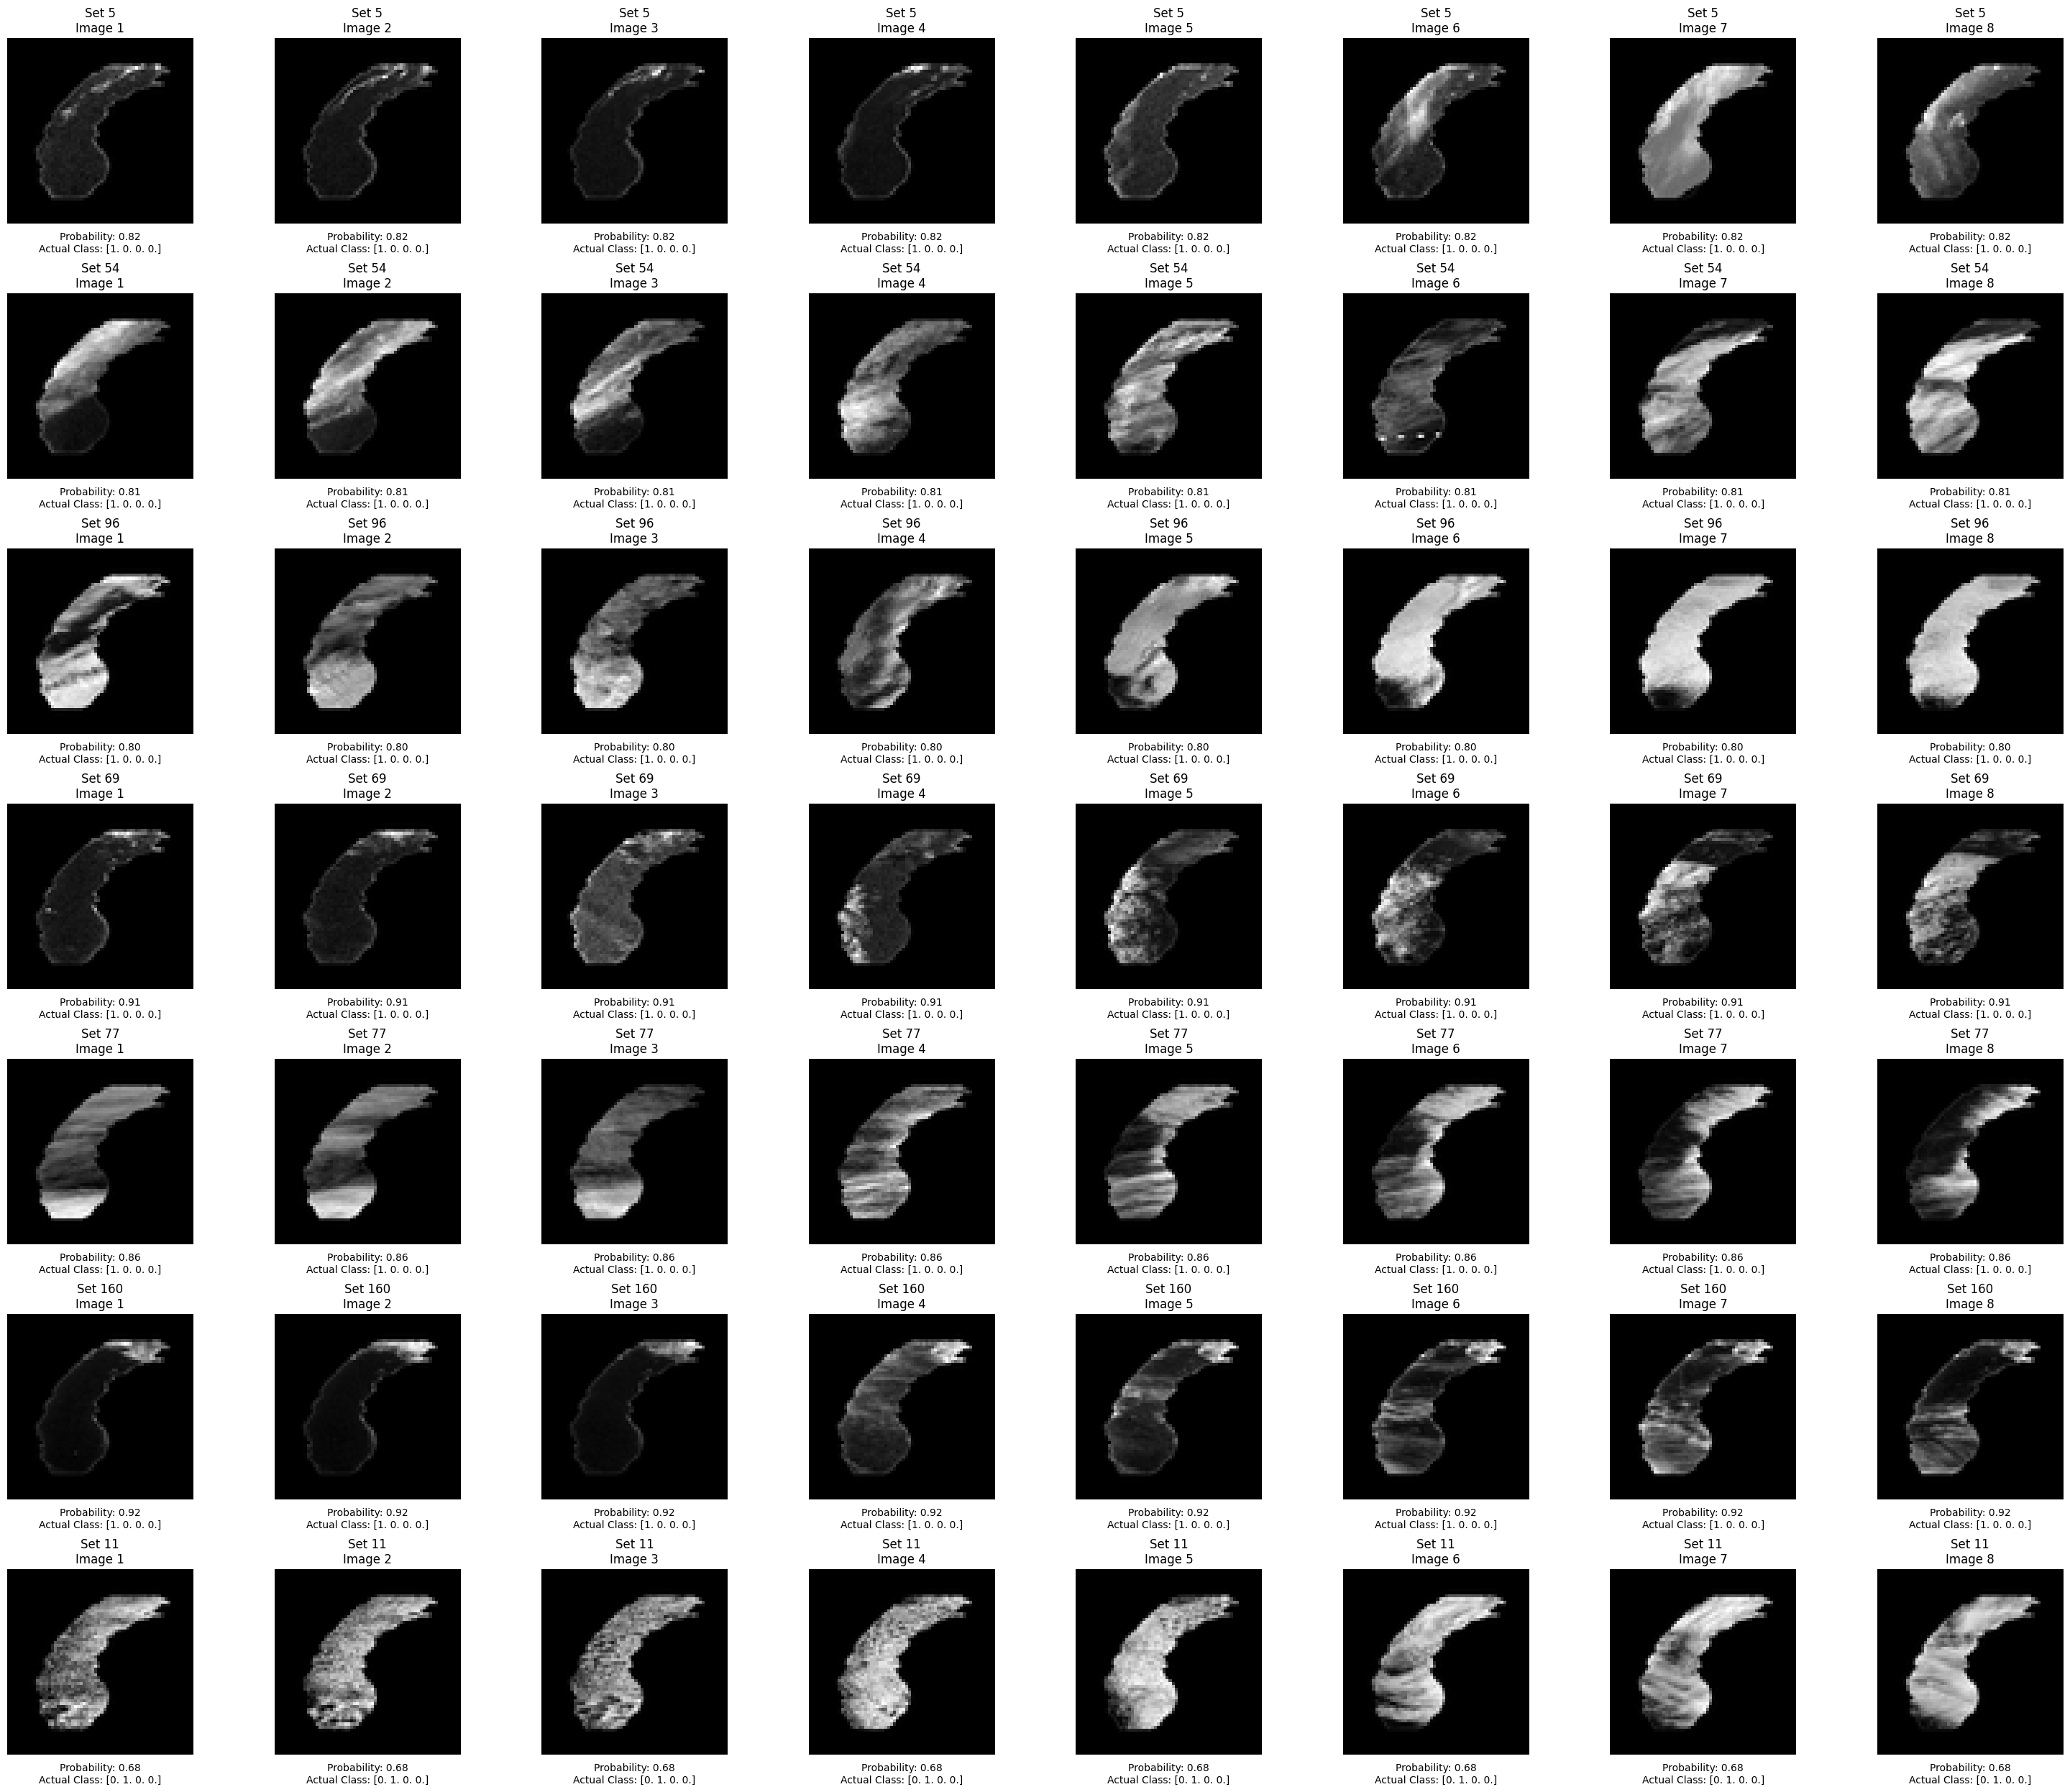

In [105]:
num_sets = [5, 54, 96,69,77,160,11] 
num_images_per_set = 8 

fig, axes = plt.subplots(7, num_images_per_set, figsize=(30, 5 * 5))
y=0
for set_idx in num_sets:
    for i in range(num_images_per_set):
        # Calculate the index in the dataset based on the set index
        
        # Display the image
        ax = axes[y, i]
        ax.imshow(cloud_val[set_idx][i][:, :, 0], cmap='gray')  
        ax.set_title(f'Set {set_idx}\nImage {i + 1}')
        ax.axis('off')  # Turn off axis
        
        probability = predictions[set_idx][0]  
        actual_class = rain_val_c_mod[set_idx] 
    
        ax.text(0.5, -0.15, f'Probability: {probability:.2f}\nActual Class: {actual_class}',
                transform=ax.transAxes, fontsize=10, ha='center')
    y+=1
plt.tight_layout()
plt.show()

**Conclusion**

We learned how to work with sequential image data that was a challenge and we combined two different models to creat one multi modal architecture

Also, we used Conv2DLSTM and the mddel stops improving after certain point as professor mentioned during the presentation it would be a better approach would have been using CONV3D-LSTM.

we can also increase the window size to make sure we have a better output for predicting more days in advance